# Lab 4 - Tensorflow Hub - using machine learning moules



[TensorFlow Hub](https://www.tensorflow.org/hub/) is a library for the publication, discovery, and consumption of reusable parts of machine learning models. A module is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks in a process known as transfer learning. 

Transfer learning can:

1. Train a model with a smaller dataset,
2. Improve generalization, and
3. Speed up training.

``` bash
pip isntall tensorflow-hub
```

> **Note**
1. TensorFlow Hub depends on bug fixes and enhancements not present in TensorFlow releases prior to 1.7. You must install or upgrade your TensorFlow package to at least 1.7 to use TensorFlow Hub.
2. Restart your jupyter after Tensorflow Hub is installed

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

with tf.Graph().as_default():
  module_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/1"
  embed = hub.Module(module_url)
  embeddings = embed(["A long sentence.", "single-word",
                      "http://example.com"])

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())

    print(sess.run(embeddings))

INFO:tensorflow:Initialize variable module/embeddings/part_0:0 from checkpoint b'C:\\Users\\rewang\\AppData\\Local\\Temp\\tfhub_modules\\2cdbcae1a547f4fb93475d4b7d4140f8590995b7\\variables\\variables' with embeddings
[[  1.27072588e-01   1.70752838e-01  -9.90944505e-02   7.04903603e-02
    2.26204265e-02  -8.07912350e-02   1.34882599e-01   9.98359919e-02
   -9.38840210e-02   1.57970995e-01   1.49555340e-01  -7.23052993e-02
    2.82968562e-02  -7.33467517e-03   7.44888186e-02  -2.56097335e-02
    1.71663105e-01  -2.87602507e-02   5.61525524e-02   1.13487214e-01
   -1.64960790e-02  -6.53510634e-03  -2.56301146e-02  -8.42670649e-02
    8.53472874e-02  -5.40463366e-02   7.97923282e-02  -1.38562024e-01
   -1.34141564e-01  -7.57983997e-02  -9.42738429e-02  -7.67866522e-02
   -1.52945921e-01   1.80598632e-01   1.54585212e-01  -1.51075236e-02
    3.27526703e-02   9.76694282e-03  -5.50296791e-02   6.87522218e-02
   -4.60033529e-02  -6.41337559e-02   9.67478678e-02   2.06821620e-01
   -3.4198038

## Retrain an Image Classifier for New Categories

https://www.tensorflow.org/hub/tutorials/image_retraining
https://raw.githubusercontent.com/tensorflow/hub/r0.1/examples/image_retraining/retrain.py

This script loads the pre-trained module (By default,
it uses the feature vectors computed by Inception V3 trained on ImageNet.
See https://github.com/tensorflow/hub/blob/r0.1/docs/modules/image.md
for more options) and trains a new classifier on top for the flower photos you've downloaded. None of the flower species were in the original ImageNet classes the full network was trained on. The magic of transfer learning is that lower layers that have been trained to distinguish between some objects can be reused for many recognition tasks without any alteration.

> if you want to deploy
on resource-limited platforms, you can try the `--tfhub_module` flag with a
Mobilenet model. For more information on Mobilenet, see
https://research.googleblog.com/2017/06/mobilenets-open-source-models-for.html

```bash

python retrain.py --image_dir flower_photos/ --tfhub_module https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/1

```


###  Bottlenecks

The script can take thirty minutes or more to complete, depending on the speed of your machine. 

The first phase analyzes all the images on disk and calculates and caches the bottleneck values for each of them. 'Bottleneck' is an informal term we often use for the layer just before the final output layer that actually does the classification. (TensorFlow Hub calls this an "image feature vector".) This penultimate layer has been trained to output a set of values that's good enough for the classifier to use to distinguish between all the classes it's been asked to recognize. That means it has to be a meaningful and compact summary of the images, since it has to contain enough information for the classifier to make a good choice in a very small set of values. The reason our final layer retraining can work on new classes is that it turns out the kind of information needed to distinguish between all the 1,000 classes in ImageNet is often also useful to distinguish between new kinds of objects.

Because every image is reused multiple times during training and calculating each bottleneck takes a significant amount of time, it speeds things up to cache these bottleneck values on disk so they don't have to be repeatedly recalculated. By default they're stored in the /tmp/bottleneck directory, and if you rerun the script they'll be reused so you don't have to wait for this part again.

### Training

Once the bottlenecks are complete, the actual training of the top layer of the network begins. You'll see a series of step outputs, each one showing **training accuracy**, **validation accuracy**, and the **cross entropy**. 

* The training accuracy shows what percent of the images used in the current training batch were labeled with the correct class. 
* The validation accuracy is the precision on a randomly-selected group of images from a different set. The key difference is that the training accuracy is based on images that the network has been able to learn from so the network can overfit to the noise in the training data. A true measure of the performance of the network is to measure its performance on a data set not contained in the training data -- this is measured by the validation accuracy. 

> If the train accuracy is high but the validation accuracy remains low, that means the network is overfitting and memorizing particular features in the training images that aren't helpful more generally. 

*  Cross entropy is a loss function which gives a glimpse into how well the learning process is progressing. The training's objective is to make the loss as small as possible, so you can tell if the learning is working by keeping an eye on whether the loss keeps trending downwards, ignoring the short-term noise.




In [4]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
# NOTICE: This work was derived from tensorflow/examples/image_retraining
# and modified to use TensorFlow Hub modules.

# pylint: disable=line-too-long
# pylint: enable=line-too-long

r"""Simple transfer learning with image modules from TensorFlow Hub.

This example shows how to train an image classifier based on any
TensorFlow Hub module that computes image feature vectors. By default,
it uses the feature vectors computed by Inception V3 trained on ImageNet.
See https://github.com/tensorflow/hub/blob/r0.1/docs/modules/image.md
for more options.

The top layer receives as input a 2048-dimensional vector (assuming
Inception V3) for each image. We train a softmax layer on top of this
representation. If the softmax layer contains N labels, this corresponds
to learning N + 2048*N model parameters for the biases and weights.

Here's an example, which assumes you have a folder containing class-named
subfolders, each full of images for each label. The example folder flower_photos
should have a structure like this:

~/flower_photos/daisy/photo1.jpg
~/flower_photos/daisy/photo2.jpg
...
~/flower_photos/rose/anotherphoto77.jpg
...
~/flower_photos/sunflower/somepicture.jpg

The subfolder names are important, since they define what label is applied to
each image, but the filenames themselves don't matter. (For a working example,
download http://download.tensorflow.org/example_images/flower_photos.tgz
and run  tar xzf flower_photos.tgz  to unpack it.)

Once your images are prepared, and you have pip-installed tensorflow-hub and
a sufficiently recent version of tensorflow, you can run the training with a
command like this:

```bash
python retrain.py --image_dir ~/flower_photos
```

You can replace the image_dir argument with any folder containing subfolders of
images. The label for each image is taken from the name of the subfolder it's
in.

This produces a new model file that can be loaded and run by any TensorFlow
program, for example the tensorflow/examples/label_image sample code.

By default this script will use the highly accurate, but comparatively large and
slow Inception V3 model architecture. It's recommended that you start with this
to validate that you have gathered good training data, but if you want to deploy
on resource-limited platforms, you can try the `--tfhub_module` flag with a
Mobilenet model. For more information on Mobilenet, see
https://research.googleblog.com/2017/06/mobilenets-open-source-models-for.html

For example:

Run floating-point version of Mobilenet:

```bash
python retrain.py --image_dir ~/flower_photos \
    --tfhub_module https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/1
```

Run Mobilenet, instrumented for quantization:

```bash
python retrain.py --image_dir ~/flower_photos/ \
    --tfhub_module https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/quantops/feature_vector/1
```

These instrumented models can be converted to fully quantized mobile models via
TensorFlow Lite.

There are different Mobilenet models to choose from, with a variety of file
size and latency options.
  - The first number can be '100', '075', '050', or '025' to control the number
    of neurons (activations of hidden layers); the number of weights (and hence
    to some extent the file size and speed) shrinks with the square of that
    fraction.
  - The second number is the input image size. You can choose '224', '192',
    '160', or '128', with smaller sizes giving faster speeds.

To use with TensorBoard:

By default, this script will log summaries to /tmp/retrain_logs directory

Visualize the summaries with this command:

tensorboard --logdir /tmp/retrain_logs

To use with Tensorflow Serving, run this tool with --saved_model_dir set
to some increasingly numbered export location under the model base path, e.g.:

```bash
python retrain.py (... other args as before ...) \
    --saved_model_dir=/tmp/saved_models/$(date +%s)/
tensorflow_model_server --port=9000 --model_name=my_image_classifier \
    --model_base_path=/tmp/saved_models/
```
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
from datetime import datetime
import hashlib
import os.path
import random
import re
import sys

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

FLAGS = None

MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1  # ~134M

# The location where variable checkpoints will be stored.

CHECKPOINT_NAME = '/tmp/_retrain_checkpoint'

# A module is understood as instrumented for quantization with TF-Lite
# if it contains any of these ops.

FAKE_QUANT_OPS = ('FakeQuantWithMinMaxVars',
                  'FakeQuantWithMinMaxVarsPerChannel')


def create_image_lists(image_dir, testing_percentage,
                       validation_percentage):
    """Builds a list of training images from the file system.

  Analyzes the sub folders in the image directory, splits them into stable
  training, testing, and validation sets, and returns a data structure
  describing the lists of images for each label and their paths.

  Args:
    image_dir: String path to a folder containing subfolders of images.
    testing_percentage: Integer percentage of the images to reserve for tests.
    validation_percentage: Integer percentage of images reserved for validation.

  Returns:
    An OrderedDict containing an entry for each label subfolder, with images
    split into training, testing, and validation sets within each label.
    The order of items defines the class indices.
  """

    if not tf.gfile.Exists(image_dir):
        tf.logging.error("Image directory '" + image_dir
                         + "' not found.")
        return None
    result = collections.OrderedDict()
    sub_dirs = sorted(x[0] for x in tf.gfile.Walk(image_dir))

  # The root directory comes first, so skip it.

    is_root_dir = True
    for sub_dir in sub_dirs:
        if is_root_dir:
            is_root_dir = False
            continue
        extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
        file_list = []
        dir_name = os.path.basename(sub_dir)
        if dir_name == image_dir:
            continue
        tf.logging.info("Looking for images in '" + dir_name + "'")
        for extension in extensions:
            file_glob = os.path.join(image_dir, dir_name, '*.'
                    + extension)
            file_list.extend(tf.gfile.Glob(file_glob))
        if not file_list:
            tf.logging.warning('No files found')
            continue
        if len(file_list) < 20:
            tf.logging.warning('WARNING: Folder has less than 20 images, which may cause issues.'
                               )
        elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
            tf.logging.warning('WARNING: Folder {} has more than {} images. Some images will never be selected.'.format(dir_name,
                               MAX_NUM_IMAGES_PER_CLASS))
        label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
        training_images = []
        testing_images = []
        validation_images = []
        for file_name in file_list:
            base_name = os.path.basename(file_name)

      # We want to ignore anything after '_nohash_' in the file name when
      # deciding which set to put an image in, the data set creator has a way of
      # grouping photos that are close variations of each other. For example
      # this is used in the plant disease data set to group multiple pictures of
      # the same leaf.

            hash_name = re.sub(r'_nohash_.*$', '', file_name)

      # This looks a bit magical, but we need to decide whether this file should
      # go into the training, testing, or validation sets, and we want to keep
      # existing files in the same set even if more files are subsequently
      # added.
      # To do that, we need a stable way of deciding based on just the file name
      # itself, so we do a hash of that and then use that to generate a
      # probability value that we use to assign it.

            hash_name_hashed = \
                hashlib.sha1(tf.compat.as_bytes(hash_name)).hexdigest()
            percentage_hash = int(hash_name_hashed, 16) \
                % (MAX_NUM_IMAGES_PER_CLASS + 1) * (100.0
                    / MAX_NUM_IMAGES_PER_CLASS)
            if percentage_hash < validation_percentage:
                validation_images.append(base_name)
            elif percentage_hash < testing_percentage \
                + validation_percentage:
                testing_images.append(base_name)
            else:
                training_images.append(base_name)
        result[label_name] = {
            'dir': dir_name,
            'training': training_images,
            'testing': testing_images,
            'validation': validation_images,
            }
    return result


def get_image_path(
    image_lists,
    label_name,
    index,
    image_dir,
    category,
    ):
    """Returns a path to an image for a label at the given index.

  Args:
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Int offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of set to pull images from - training, testing, or
    validation.

  Returns:
    File system path string to an image that meets the requested parameters.

  """

    if label_name not in image_lists:
        tf.logging.fatal('Label does not exist %s.', label_name)
    label_lists = image_lists[label_name]
    if category not in label_lists:
        tf.logging.fatal('Category does not exist %s.', category)
    category_list = label_lists[category]
    if not category_list:
        tf.logging.fatal('Label %s has no images in the category %s.',
                         label_name, category)
    mod_index = index % len(category_list)
    base_name = category_list[mod_index]
    sub_dir = label_lists['dir']
    full_path = os.path.join(image_dir, sub_dir, base_name)
    return full_path


def get_bottleneck_path(
    image_lists,
    label_name,
    index,
    bottleneck_dir,
    category,
    module_name,
    ):
    """Returns a path to a bottleneck file for a label at the given index.

  Args:
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    category: Name string of set to pull images from - training, testing, or
    validation.
    module_name: The name of the image module being used.

  Returns:
    File system path string to an image that meets the requested parameters.
  """

    module_name = module_name.replace('://', '~').replace('/', '~'
            ).replace(':', '~').replace('\\', '~')  # URL scheme.
                                                    # URL and Unix paths.
                                                    # Windows paths.
    return get_image_path(image_lists, label_name, index,
                          bottleneck_dir, category) + '_' + module_name \
        + '.txt'


def create_module_graph(module_spec):
    """Creates a graph and loads Hub Module into it.

  Args:
    module_spec: the hub.ModuleSpec for the image module being used.

  Returns:
    graph: the tf.Graph that was created.
    bottleneck_tensor: the bottleneck values output by the module.
    resized_input_tensor: the input images, resized as expected by the module.
    wants_quantization: a boolean, whether the module has been instrumented
      with fake quantization ops.
  """

    (height, width) = hub.get_expected_image_size(module_spec)
    with tf.Graph().as_default() as graph:
        resized_input_tensor = tf.placeholder(tf.float32, [None,
                height, width, 3])
        m = hub.Module(module_spec)
        bottleneck_tensor = m(resized_input_tensor)
        wants_quantization = any(node.op in FAKE_QUANT_OPS for node in
                                 graph.as_graph_def().node)
    return (graph, bottleneck_tensor, resized_input_tensor,
            wants_quantization)


def run_bottleneck_on_image(
    sess,
    image_data,
    image_data_tensor,
    decoded_image_tensor,
    resized_input_tensor,
    bottleneck_tensor,
    ):
    """Runs inference on an image to extract the 'bottleneck' summary layer.

  Args:
    sess: Current active TensorFlow Session.
    image_data: String of raw JPEG data.
    image_data_tensor: Input data layer in the graph.
    decoded_image_tensor: Output of initial image resizing and preprocessing.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: Layer before the final softmax.

  Returns:
    Numpy array of bottleneck values.
  """

  # First decode the JPEG image, resize it, and rescale the pixel values.

    resized_input_values = sess.run(decoded_image_tensor,
                                    {image_data_tensor: image_data})

  # Then run it through the recognition network.

    bottleneck_values = sess.run(bottleneck_tensor,
                                 {resized_input_tensor: resized_input_values})
    bottleneck_values = np.squeeze(bottleneck_values)
    return bottleneck_values


def ensure_dir_exists(dir_name):
    """Makes sure the folder exists on disk.

  Args:
    dir_name: Path string to the folder we want to create.
  """

    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


def create_bottleneck_file(
    bottleneck_path,
    image_lists,
    label_name,
    index,
    image_dir,
    category,
    sess,
    jpeg_data_tensor,
    decoded_image_tensor,
    resized_input_tensor,
    bottleneck_tensor,
    ):
    """Create a single bottleneck file."""

    tf.logging.info('Creating bottleneck at ' + bottleneck_path)
    image_path = get_image_path(image_lists, label_name, index,
                                image_dir, category)
    if not tf.gfile.Exists(image_path):
        tf.logging.fatal('File does not exist %s', image_path)
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
    try:
        bottleneck_values = run_bottleneck_on_image(
            sess,
            image_data,
            jpeg_data_tensor,
            decoded_image_tensor,
            resized_input_tensor,
            bottleneck_tensor,
            )
    except Exception as e:
        raise RuntimeError('Error during processing file %s (%s)'
                           % (image_path, str(e)))
    bottleneck_string = ','.join(str(x) for x in bottleneck_values)
    with open(bottleneck_path, 'w') as bottleneck_file:
        bottleneck_file.write(bottleneck_string)


def get_or_create_bottleneck(
    sess,
    image_lists,
    label_name,
    index,
    image_dir,
    category,
    bottleneck_dir,
    jpeg_data_tensor,
    decoded_image_tensor,
    resized_input_tensor,
    bottleneck_tensor,
    module_name,
    ):
    """Retrieves or calculates bottleneck values for an image.

  If a cached version of the bottleneck data exists on-disk, return that,
  otherwise calculate the data and save it to disk for future use.

  Args:
    sess: The current active TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be modulo-ed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of which set to pull images from - training, testing,
    or validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    jpeg_data_tensor: The tensor to feed loaded jpeg data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The output tensor for the bottleneck values.
    module_name: The name of the image module being used.

  Returns:
    Numpy array of values produced by the bottleneck layer for the image.
  """

    label_lists = image_lists[label_name]
    sub_dir = label_lists['dir']
    sub_dir_path = os.path.join(bottleneck_dir, sub_dir)
    ensure_dir_exists(sub_dir_path)
    bottleneck_path = get_bottleneck_path(
        image_lists,
        label_name,
        index,
        bottleneck_dir,
        category,
        module_name,
        )
    if not os.path.exists(bottleneck_path):
        create_bottleneck_file(
            bottleneck_path,
            image_lists,
            label_name,
            index,
            image_dir,
            category,
            sess,
            jpeg_data_tensor,
            decoded_image_tensor,
            resized_input_tensor,
            bottleneck_tensor,
            )
    with open(bottleneck_path, 'r') as bottleneck_file:
        bottleneck_string = bottleneck_file.read()
    did_hit_error = False
    try:
        bottleneck_values = [float(x) for x in
                             bottleneck_string.split(',')]
    except ValueError:
        tf.logging.warning('Invalid float found, recreating bottleneck')
        did_hit_error = True
    if did_hit_error:
        create_bottleneck_file(
            bottleneck_path,
            image_lists,
            label_name,
            index,
            image_dir,
            category,
            sess,
            jpeg_data_tensor,
            decoded_image_tensor,
            resized_input_tensor,
            bottleneck_tensor,
            )
        with open(bottleneck_path, 'r') as bottleneck_file:
            bottleneck_string = bottleneck_file.read()

    # Allow exceptions to propagate here, since they shouldn't happen after a
    # fresh creation

        bottleneck_values = [float(x) for x in
                             bottleneck_string.split(',')]
    return bottleneck_values


def cache_bottlenecks(
    sess,
    image_lists,
    image_dir,
    bottleneck_dir,
    jpeg_data_tensor,
    decoded_image_tensor,
    resized_input_tensor,
    bottleneck_tensor,
    module_name,
    ):
    """Ensures all the training, testing, and validation bottlenecks are cached.

  Because we're likely to read the same image multiple times (if there are no
  distortions applied during training) it can speed things up a lot if we
  calculate the bottleneck layer values once for each image during
  preprocessing, and then just read those cached values repeatedly during
  training. Here we go through all the images we've found, calculate those
  values, and save them off.

  Args:
    sess: The current active TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    image_dir: Root folder string of the subfolders containing the training
    images.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    jpeg_data_tensor: Input tensor for jpeg data from file.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The penultimate output layer of the graph.
    module_name: The name of the image module being used.

  Returns:
    Nothing.
  """

    how_many_bottlenecks = 0
    ensure_dir_exists(bottleneck_dir)
    for (label_name, label_lists) in image_lists.items():
        for category in ['training', 'testing', 'validation']:
            category_list = label_lists[category]
            for (index, unused_base_name) in enumerate(category_list):
                get_or_create_bottleneck(
                    sess,
                    image_lists,
                    label_name,
                    index,
                    image_dir,
                    category,
                    bottleneck_dir,
                    jpeg_data_tensor,
                    decoded_image_tensor,
                    resized_input_tensor,
                    bottleneck_tensor,
                    module_name,
                    )

                how_many_bottlenecks += 1
                if how_many_bottlenecks % 100 == 0:
                    tf.logging.info(str(how_many_bottlenecks)
                                    + ' bottleneck files created.')


def get_random_cached_bottlenecks(
    sess,
    image_lists,
    how_many,
    category,
    bottleneck_dir,
    image_dir,
    jpeg_data_tensor,
    decoded_image_tensor,
    resized_input_tensor,
    bottleneck_tensor,
    module_name,
    ):
    """Retrieves bottleneck values for cached images.

  If no distortions are being applied, this function can retrieve the cached
  bottleneck values directly from disk for images. It picks a random set of
  images from the specified category.

  Args:
    sess: Current TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    how_many: If positive, a random sample of this size will be chosen.
    If negative, all bottlenecks will be retrieved.
    category: Name string of which set to pull from - training, testing, or
    validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_dir: Root folder string of the subfolders containing the training
    images.
    jpeg_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
    module_name: The name of the image module being used.

  Returns:
    List of bottleneck arrays, their corresponding ground truths, and the
    relevant filenames.
  """

    class_count = len(image_lists.keys())
    bottlenecks = []
    ground_truths = []
    filenames = []
    if how_many >= 0:

    # Retrieve a random sample of bottlenecks.

        for unused_i in range(how_many):
            label_index = random.randrange(class_count)
            label_name = list(image_lists.keys())[label_index]
            image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
            image_name = get_image_path(image_lists, label_name,
                    image_index, image_dir, category)
            bottleneck = get_or_create_bottleneck(
                sess,
                image_lists,
                label_name,
                image_index,
                image_dir,
                category,
                bottleneck_dir,
                jpeg_data_tensor,
                decoded_image_tensor,
                resized_input_tensor,
                bottleneck_tensor,
                module_name,
                )
            bottlenecks.append(bottleneck)
            ground_truths.append(label_index)
            filenames.append(image_name)
    else:

    # Retrieve all bottlenecks.

        for (label_index, label_name) in enumerate(image_lists.keys()):
            for (image_index, image_name) in \
                enumerate(image_lists[label_name][category]):
                image_name = get_image_path(image_lists, label_name,
                        image_index, image_dir, category)
                bottleneck = get_or_create_bottleneck(
                    sess,
                    image_lists,
                    label_name,
                    image_index,
                    image_dir,
                    category,
                    bottleneck_dir,
                    jpeg_data_tensor,
                    decoded_image_tensor,
                    resized_input_tensor,
                    bottleneck_tensor,
                    module_name,
                    )
                bottlenecks.append(bottleneck)
                ground_truths.append(label_index)
                filenames.append(image_name)
    return (bottlenecks, ground_truths, filenames)


def get_random_distorted_bottlenecks(
    sess,
    image_lists,
    how_many,
    category,
    image_dir,
    input_jpeg_tensor,
    distorted_image,
    resized_input_tensor,
    bottleneck_tensor,
    ):
    """Retrieves bottleneck values for training images, after distortions.

  If we're training with distortions like crops, scales, or flips, we have to
  recalculate the full model for every image, and so we can't use cached
  bottleneck values. Instead we find random images for the requested category,
  run them through the distortion graph, and then the full graph to get the
  bottleneck results for each.

  Args:
    sess: Current TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    how_many: The integer number of bottleneck values to return.
    category: Name string of which set of images to fetch - training, testing,
    or validation.
    image_dir: Root folder string of the subfolders containing the training
    images.
    input_jpeg_tensor: The input layer we feed the image data to.
    distorted_image: The output node of the distortion graph.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.

  Returns:
    List of bottleneck arrays and their corresponding ground truths.
  """

    class_count = len(image_lists.keys())
    bottlenecks = []
    ground_truths = []
    for unused_i in range(how_many):
        label_index = random.randrange(class_count)
        label_name = list(image_lists.keys())[label_index]
        image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
        image_path = get_image_path(image_lists, label_name,
                                    image_index, image_dir, category)
        if not tf.gfile.Exists(image_path):
            tf.logging.fatal('File does not exist %s', image_path)
        jpeg_data = tf.gfile.FastGFile(image_path, 'rb').read()

    # Note that we materialize the distorted_image_data as a numpy array before
    # sending running inference on the image. This involves 2 memory copies and
    # might be optimized in other implementations.

        distorted_image_data = sess.run(distorted_image,
                {input_jpeg_tensor: jpeg_data})
        bottleneck_values = sess.run(bottleneck_tensor,
                {resized_input_tensor: distorted_image_data})
        bottleneck_values = np.squeeze(bottleneck_values)
        bottlenecks.append(bottleneck_values)
        ground_truths.append(label_index)
    return (bottlenecks, ground_truths)


def should_distort_images(
    flip_left_right,
    random_crop,
    random_scale,
    random_brightness,
    ):
    """Whether any distortions are enabled, from the input flags.

  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.

  Returns:
    Boolean value indicating whether any distortions should be applied.
  """

    return flip_left_right or random_crop != 0 or random_scale != 0 \
        or random_brightness != 0


def add_input_distortions(
    flip_left_right,
    random_crop,
    random_scale,
    random_brightness,
    module_spec,
    ):
    """Creates the operations to apply the specified distortions.

  During training it can help to improve the results if we run the images
  through simple distortions like crops, scales, and flips. These reflect the
  kind of variations we expect in the real world, and so can help train the
  model to cope with natural data more effectively. Here we take the supplied
  parameters and construct a network of operations to apply them to an image.

  Cropping
  ~~~~~~~~

  Cropping is done by placing a bounding box at a random position in the full
  image. The cropping parameter controls the size of that box relative to the
  input image. If it's zero, then the box is the same size as the input and no
  cropping is performed. If the value is 50%, then the crop box will be half the
  width and height of the input. In a diagram it looks like this:

  <       width         >
  +---------------------+
  |                     |
  |   width - crop%     |
  |    <      >         |
  |    +------+         |
  |    |      |         |
  |    |      |         |
  |    |      |         |
  |    +------+         |
  |                     |
  |                     |
  +---------------------+

  Scaling
  ~~~~~~~

  Scaling is a lot like cropping, except that the bounding box is always
  centered and its size varies randomly within the given range. For example if
  the scale percentage is zero, then the bounding box is the same size as the
  input and no scaling is applied. If it's 50%, then the bounding box will be in
  a random range between half the width and height and full size.

  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.
    graph.
    module_spec: The hub.ModuleSpec for the image module being used.

  Returns:
    The jpeg input layer and the distorted result tensor.
  """

    (input_height, input_width) = \
        hub.get_expected_image_size(module_spec)
    input_depth = hub.get_num_image_channels(module_spec)
    jpeg_data = tf.placeholder(tf.string, name='DistortJPGInput')
    decoded_image = tf.image.decode_jpeg(jpeg_data,
            channels=input_depth)

  # Convert from full range of uint8 to range [0,1] of float32.

    decoded_image_as_float = \
        tf.image.convert_image_dtype(decoded_image, tf.float32)
    decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
    margin_scale = 1.0 + random_crop / 100.0
    resize_scale = 1.0 + random_scale / 100.0
    margin_scale_value = tf.constant(margin_scale)
    resize_scale_value = tf.random_uniform(shape=[], minval=1.0,
            maxval=resize_scale)
    scale_value = tf.multiply(margin_scale_value, resize_scale_value)
    precrop_width = tf.multiply(scale_value, input_width)
    precrop_height = tf.multiply(scale_value, input_height)
    precrop_shape = tf.stack([precrop_height, precrop_width])
    precrop_shape_as_int = tf.cast(precrop_shape, dtype=tf.int32)
    precropped_image = tf.image.resize_bilinear(decoded_image_4d,
            precrop_shape_as_int)
    precropped_image_3d = tf.squeeze(precropped_image, squeeze_dims=[0])
    cropped_image = tf.random_crop(precropped_image_3d, [input_height,
                                   input_width, input_depth])
    if flip_left_right:
        flipped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        flipped_image = cropped_image
    brightness_min = 1.0 - random_brightness / 100.0
    brightness_max = 1.0 + random_brightness / 100.0
    brightness_value = tf.random_uniform(shape=[],
            minval=brightness_min, maxval=brightness_max)
    brightened_image = tf.multiply(flipped_image, brightness_value)
    distort_result = tf.expand_dims(brightened_image, 0,
                                    name='DistortResult')
    return (jpeg_data, distort_result)


def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""

    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


def add_final_retrain_ops(
    class_count,
    final_tensor_name,
    bottleneck_tensor,
    quantize_layer,
    is_training,
    ):
    """Adds a new softmax and fully-connected layer for training and eval.

  We need to retrain the top layer to identify our new classes, so this function
  adds the right operations to the graph, along with some variables to hold the
  weights, and then sets up all the gradients for the backward pass.

  The set up for the softmax and fully-connected layers is based on:
  https://www.tensorflow.org/tutorials/mnist/beginners/index.html

  Args:
    class_count: Integer of how many categories of things we're trying to
        recognize.
    final_tensor_name: Name string for the new final node that produces results.
    bottleneck_tensor: The output of the main CNN graph.
    quantize_layer: Boolean, specifying whether the newly added layer should be
        instrumented for quantization with TF-Lite.
    is_training: Boolean, specifying whether the newly add layer is for training
        or eval.

  Returns:
    The tensors for the training and cross entropy results, and tensors for the
    bottleneck input and ground truth input.
  """

    (batch_size, bottleneck_tensor_size) = \
        bottleneck_tensor.get_shape().as_list()
    assert batch_size is None, \
        'We want to work with arbitrary batch size.'
    with tf.name_scope('input'):
        bottleneck_input = \
            tf.placeholder_with_default(bottleneck_tensor,
                shape=[batch_size, bottleneck_tensor_size],
                name='BottleneckInputPlaceholder')

        ground_truth_input = tf.placeholder(tf.int64, [batch_size],
                name='GroundTruthInput')

  # Organizing the following ops so they are easier to see in TensorBoard.

    layer_name = 'final_retrain_ops'
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            initial_value = \
                tf.truncated_normal([bottleneck_tensor_size,
                                    class_count], stddev=0.001)
            layer_weights = tf.Variable(initial_value,
                    name='final_weights')
            variable_summaries(layer_weights)

        with tf.name_scope('biases'):
            layer_biases = tf.Variable(tf.zeros([class_count]),
                    name='final_biases')
            variable_summaries(layer_biases)

        with tf.name_scope('Wx_plus_b'):
            logits = tf.matmul(bottleneck_input, layer_weights) \
                + layer_biases
            tf.summary.histogram('pre_activations', logits)

    final_tensor = tf.nn.softmax(logits, name=final_tensor_name)

  # The tf.contrib.quantize functions rewrite the graph in place for
  # quantization. The imported model graph has already been rewritten, so upon
  # calling these rewrites, only the newly added final layer will be
  # transformed.

    if quantize_layer:
        if is_training:
            tf.contrib.quantize.create_training_graph()
        else:
            tf.contrib.quantize.create_eval_graph()

    tf.summary.histogram('activations', final_tensor)

  # If this is an eval graph, we don't need to add loss ops or an optimizer.

    if not is_training:
        return (None, None, bottleneck_input, ground_truth_input,
                final_tensor)

    with tf.name_scope('cross_entropy'):
        cross_entropy_mean = \
            tf.losses.sparse_softmax_cross_entropy(labels=ground_truth_input,
                logits=logits)

    tf.summary.scalar('cross_entropy', cross_entropy_mean)

    with tf.name_scope('train'):
        optimizer = \
            tf.train.GradientDescentOptimizer(FLAGS.learning_rate)
        train_step = optimizer.minimize(cross_entropy_mean)

    return (train_step, cross_entropy_mean, bottleneck_input,
            ground_truth_input, final_tensor)


def add_evaluation_step(result_tensor, ground_truth_tensor):
    """Inserts the operations we need to evaluate the accuracy of our results.

  Args:
    result_tensor: The new final node that produces results.
    ground_truth_tensor: The node we feed ground truth data
    into.

  Returns:
    Tuple of (evaluation step, prediction).
  """

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            prediction = tf.argmax(result_tensor, 1)
            correct_prediction = tf.equal(prediction,
                    ground_truth_tensor)
        with tf.name_scope('accuracy'):
            evaluation_step = \
                tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', evaluation_step)
    return (evaluation_step, prediction)


def run_final_eval(
    train_session,
    module_spec,
    class_count,
    image_lists,
    jpeg_data_tensor,
    decoded_image_tensor,
    resized_image_tensor,
    bottleneck_tensor,
    ):
    """Runs a final evaluation on an eval graph using the test data set.

  Args:
    train_session: Session for the train graph with the tensors below.
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes
    image_lists: OrderedDict of training images for each label.
    jpeg_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_image_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
  """

    (test_bottlenecks, test_ground_truth, test_filenames) = \
        get_random_cached_bottlenecks(
        train_session,
        image_lists,
        FLAGS.test_batch_size,
        'testing',
        FLAGS.bottleneck_dir,
        FLAGS.image_dir,
        jpeg_data_tensor,
        decoded_image_tensor,
        resized_image_tensor,
        bottleneck_tensor,
        FLAGS.tfhub_module,
        )

    (
        eval_session,
        _,
        bottleneck_input,
        ground_truth_input,
        evaluation_step,
        prediction,
        ) = build_eval_session(module_spec, class_count)
    (test_accuracy, predictions) = eval_session.run([evaluation_step,
            prediction], feed_dict={bottleneck_input: test_bottlenecks,
            ground_truth_input: test_ground_truth})
    tf.logging.info('Final test accuracy = %.1f%% (N=%d)'
                    % (test_accuracy * 100, len(test_bottlenecks)))

    if FLAGS.print_misclassified_test_images:
        tf.logging.info('=== MISCLASSIFIED TEST IMAGES ===')
        for (i, test_filename) in enumerate(test_filenames):
            if predictions[i] != test_ground_truth[i]:
                tf.logging.info('%70s  %s' % (test_filename,
                                list(image_lists.keys())[predictions[i]]))


def build_eval_session(module_spec, class_count):
    """Builds an restored eval session without train operations for exporting.

  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes

  Returns:
    Eval session containing the restored eval graph.
    The bottleneck input, ground truth, eval step, and prediction tensors.
  """

  # If quantized, we need to create the correct eval graph for exporting.

    (eval_graph, bottleneck_tensor, resized_input_tensor,
     wants_quantization) = create_module_graph(module_spec)

    eval_sess = tf.Session(graph=eval_graph)
    with eval_graph.as_default():

    # Add the new layer for exporting.

        (_, _, bottleneck_input, ground_truth_input, final_tensor) = \
            add_final_retrain_ops(class_count, FLAGS.final_tensor_name,
                                  bottleneck_tensor,
                                  wants_quantization, is_training=False)

    # Now we need to restore the values from the training graph to the eval
    # graph.

        tf.train.Saver().restore(eval_sess, CHECKPOINT_NAME)

        (evaluation_step, prediction) = \
            add_evaluation_step(final_tensor, ground_truth_input)

    return (
        eval_sess,
        resized_input_tensor,
        bottleneck_input,
        ground_truth_input,
        evaluation_step,
        prediction,
        )


def save_graph_to_file(
    graph,
    graph_file_name,
    module_spec,
    class_count,
    ):
    """Saves an graph to file, creating a valid quantized one if necessary."""

    (
        sess,
        _,
        _,
        _,
        _,
        _,
        ) = build_eval_session(module_spec, class_count)
    graph = sess.graph

    output_graph_def = \
        tf.graph_util.convert_variables_to_constants(sess,
            graph.as_graph_def(), [FLAGS.final_tensor_name])

    with tf.gfile.FastGFile(graph_file_name, 'wb') as f:
        f.write(output_graph_def.SerializeToString())


def prepare_file_system():

  # Setup the directory we'll write summaries to for TensorBoard

    if tf.gfile.Exists(FLAGS.summaries_dir):
        tf.gfile.DeleteRecursively(FLAGS.summaries_dir)
    tf.gfile.MakeDirs(FLAGS.summaries_dir)
    if FLAGS.intermediate_store_frequency > 0:
        ensure_dir_exists(FLAGS.intermediate_output_graphs_dir)
    return


def add_jpeg_decoding(module_spec):
    """Adds operations that perform JPEG decoding and resizing to the graph..

  Args:
    module_spec: The hub.ModuleSpec for the image module being used.

  Returns:
    Tensors for the node to feed JPEG data into, and the output of the
      preprocessing steps.
  """

    (input_height, input_width) = \
        hub.get_expected_image_size(module_spec)
    input_depth = hub.get_num_image_channels(module_spec)
    jpeg_data = tf.placeholder(tf.string, name='DecodeJPGInput')
    decoded_image = tf.image.decode_jpeg(jpeg_data,
            channels=input_depth)

  # Convert from full range of uint8 to range [0,1] of float32.

    decoded_image_as_float = \
        tf.image.convert_image_dtype(decoded_image, tf.float32)
    decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
    resize_shape = tf.stack([input_height, input_width])
    resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
    resized_image = tf.image.resize_bilinear(decoded_image_4d,
            resize_shape_as_int)
    return (jpeg_data, resized_image)


def export_model(module_spec, class_count, saved_model_dir):
    """Exports model for serving.

  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: The number of classes.
    saved_model_dir: Directory in which to save exported model and variables.
  """

  # The SavedModel should hold the eval graph.

    (
        sess,
        in_image,
        _,
        _,
        _,
        _,
        ) = build_eval_session(module_spec, class_count)
    graph = sess.graph
    with graph.as_default():
        inputs = \
            {'image': tf.saved_model.utils.build_tensor_info(in_image)}

        out_classes = sess.graph.get_tensor_by_name('final_result:0')
        outputs = \
            {'prediction': tf.saved_model.utils.build_tensor_info(out_classes)}

        signature = \
            tf.saved_model.signature_def_utils.build_signature_def(inputs=inputs,
                outputs=outputs,
                method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME)

        legacy_init_op = tf.group(tf.tables_initializer(),
                                  name='legacy_init_op')

    # Save out the SavedModel.

        builder = \
            tf.saved_model.builder.SavedModelBuilder(saved_model_dir)
        builder.add_meta_graph_and_variables(sess,
                [tf.saved_model.tag_constants.SERVING],
                signature_def_map={tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature},
                legacy_init_op=legacy_init_op)
        builder.save()


def main(_):

  # Needed to make sure the logging output is visible.
  # See https://github.com/tensorflow/tensorflow/issues/3047

    tf.logging.set_verbosity(tf.logging.INFO)
    if not FLAGS.image_dir:
        FLAGS.image_dir="flower_photos/"

    if not FLAGS.image_dir:
        tf.logging.error('Must set flag --image_dir.')
        return -1

  # Prepare necessary directories that can be used during training

    prepare_file_system()

  # Look at the folder structure, and create lists of all the images.

    image_lists = create_image_lists(FLAGS.image_dir,
            FLAGS.testing_percentage, FLAGS.validation_percentage)
    
    '''debug'''
    #print("Image List dump:",image_lists)

    class_count = len(image_lists.keys())
    if class_count == 0:
        tf.logging.error('No valid folders of images found at '
                         + FLAGS.image_dir)
        return -1
    if class_count == 1:
        tf.logging.error('Only one valid folder of images found at '
                         + FLAGS.image_dir
                         + ' - multiple classes are needed for classification.'
                         )
        return -1

  # See if the command-line flags mean we're applying any distortions.

    do_distort_images = should_distort_images(FLAGS.flip_left_right,
            FLAGS.random_crop, FLAGS.random_scale,
            FLAGS.random_brightness)

  # Set up the pre-trained graph.

    module_spec = hub.load_module_spec(FLAGS.tfhub_module)
    (graph, bottleneck_tensor, resized_image_tensor,
     wants_quantization) = create_module_graph(module_spec)

  # Add the new layer that we'll be training.

    with graph.as_default():

        (train_step, cross_entropy, bottleneck_input,
         ground_truth_input, final_tensor) = \
            add_final_retrain_ops(class_count, FLAGS.final_tensor_name,
                                  bottleneck_tensor,
                                  wants_quantization, is_training=True)

    with tf.Session(graph=graph) as sess:

    # Initialize all weights: for the module to their pretrained values,
    # and for the newly added retraining layer to random initial values.

        init = tf.global_variables_initializer()
        sess.run(init)

    # Set up the image decoding sub-graph.

        (jpeg_data_tensor, decoded_image_tensor) = \
            add_jpeg_decoding(module_spec)

        if do_distort_images:

      # We will be applying distortions, so setup the operations we'll need.

            (distorted_jpeg_data_tensor, distorted_image_tensor) = \
                add_input_distortions(FLAGS.flip_left_right,
                    FLAGS.random_crop, FLAGS.random_scale,
                    FLAGS.random_brightness, module_spec)
        else:

      # We'll make sure we've calculated the 'bottleneck' image summaries and
      # cached them on disk.

            cache_bottlenecks(
                sess,
                image_lists,
                FLAGS.image_dir,
                FLAGS.bottleneck_dir,
                jpeg_data_tensor,
                decoded_image_tensor,
                resized_image_tensor,
                bottleneck_tensor,
                FLAGS.tfhub_module,
                )

    # Create the operations we need to evaluate the accuracy of our new layer.

        (evaluation_step, _) = add_evaluation_step(final_tensor,
                ground_truth_input)

    # Merge all the summaries and write them out to the summaries_dir

        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(FLAGS.summaries_dir
                + '/train', sess.graph)

        validation_writer = tf.summary.FileWriter(FLAGS.summaries_dir
                + '/validation')

    # Create a train saver that is used to restore values into an eval graph
    # when exporting models.

        train_saver = tf.train.Saver()

    # Run the training for as many cycles as requested on the command line.

        for i in range(FLAGS.how_many_training_steps):

      # Get a batch of input bottleneck values, either calculated fresh every
      # time with distortions applied, or from the cache stored on disk.

            if do_distort_images:

                (train_bottlenecks, train_ground_truth) = \
                    get_random_distorted_bottlenecks(
                    sess,
                    image_lists,
                    FLAGS.train_batch_size,
                    'training',
                    FLAGS.image_dir,
                    distorted_jpeg_data_tensor,
                    distorted_image_tensor,
                    resized_image_tensor,
                    bottleneck_tensor,
                    )
            else:

                (train_bottlenecks, train_ground_truth, _) = \
                    get_random_cached_bottlenecks(
                    sess,
                    image_lists,
                    FLAGS.train_batch_size,
                    'training',
                    FLAGS.bottleneck_dir,
                    FLAGS.image_dir,
                    jpeg_data_tensor,
                    decoded_image_tensor,
                    resized_image_tensor,
                    bottleneck_tensor,
                    FLAGS.tfhub_module,
                    )

      # Feed the bottlenecks and ground truth into the graph, and run a training
      # step. Capture training summaries for TensorBoard with the `merged` op.

            (train_summary, _) = sess.run([merged, train_step],
                    feed_dict={bottleneck_input: train_bottlenecks,
                    ground_truth_input: train_ground_truth})
            train_writer.add_summary(train_summary, i)

      # Every so often, print out how well the graph is training.

            is_last_step = i + 1 == FLAGS.how_many_training_steps
            if i % FLAGS.eval_step_interval == 0 or is_last_step:
                (train_accuracy, cross_entropy_value) = \
                    sess.run([evaluation_step, cross_entropy],
                             feed_dict={bottleneck_input: train_bottlenecks,
                             ground_truth_input: train_ground_truth})
                tf.logging.info('%s: Step %d: Train accuracy = %.1f%%'
                                % (datetime.now(), i, train_accuracy
                                * 100))
                tf.logging.info('%s: Step %d: Cross entropy = %f'
                                % (datetime.now(), i,
                                cross_entropy_value))

        # TODO: Make this use an eval graph, to avoid quantization
        # moving averages being updated by the validation set, though in
        # practice this makes a negligable difference.

                (validation_bottlenecks, validation_ground_truth, _) = \
                    get_random_cached_bottlenecks(
                    sess,
                    image_lists,
                    FLAGS.validation_batch_size,
                    'validation',
                    FLAGS.bottleneck_dir,
                    FLAGS.image_dir,
                    jpeg_data_tensor,
                    decoded_image_tensor,
                    resized_image_tensor,
                    bottleneck_tensor,
                    FLAGS.tfhub_module,
                    )

        # Run a validation step and capture training summaries for TensorBoard
        # with the `merged` op.

                (validation_summary, validation_accuracy) = \
                    sess.run([merged, evaluation_step],
                             feed_dict={bottleneck_input: validation_bottlenecks,
                             ground_truth_input: validation_ground_truth})
                validation_writer.add_summary(validation_summary, i)
                tf.logging.info('%s: Step %d: Validation accuracy = %.1f%% (N=%d)'
                                 % (datetime.now(), i,
                                validation_accuracy * 100,
                                len(validation_bottlenecks)))

      # Store intermediate results

            intermediate_frequency = FLAGS.intermediate_store_frequency

            if intermediate_frequency > 0 and i \
                % intermediate_frequency == 0 and i > 0:

        # If we want to do an intermediate save, save a checkpoint of the train
        # graph, to restore into the eval graph.

                train_saver.save(sess, CHECKPOINT_NAME)
                intermediate_file_name = \
                    FLAGS.intermediate_output_graphs_dir \
                    + 'intermediate_' + str(i) + '.pb'
                tf.logging.info('Save intermediate result to : '
                                + intermediate_file_name)
                save_graph_to_file(graph, intermediate_file_name,
                                   module_spec, class_count)

    # After training is complete, force one last save of the train checkpoint.

        train_saver.save(sess, CHECKPOINT_NAME)

    # We've completed all our training, so run a final test evaluation on
    # some new images we haven't used before.

        run_final_eval(
            sess,
            module_spec,
            class_count,
            image_lists,
            jpeg_data_tensor,
            decoded_image_tensor,
            resized_image_tensor,
            bottleneck_tensor,
            )

    # Write out the trained graph and labels with the weights stored as
    # constants.

        tf.logging.info('Save final result to : ' + FLAGS.output_graph)
        if wants_quantization:
            tf.logging.info('The model is instrumented for quantization with TF-Lite'
                            )
        save_graph_to_file(graph, FLAGS.output_graph, module_spec,
                           class_count)
        with tf.gfile.FastGFile(FLAGS.output_labels, 'w') as f:
            f.write('\n'.join(image_lists.keys()) + '\n')

        if FLAGS.saved_model_dir:
            export_model(module_spec, class_count,
                         FLAGS.saved_model_dir)


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--image_dir', type=str, default='',
                        help='Path to folders of labeled images.')
    parser.add_argument('--output_graph', type=str,
                        default='/tmp/output_graph.pb',
                        help='Where to save the trained graph.')
    parser.add_argument('--intermediate_output_graphs_dir', type=str,
                        default='/tmp/intermediate_graph/',
                        help='Where to save the intermediate graphs.')
    parser.add_argument('--intermediate_store_frequency', type=int,
                        default=0,
                        help="""\
         How many steps to store intermediate graph. If "0" then will not
         store.\
      """
                        )
    parser.add_argument('--output_labels', type=str,
                        default='/tmp/output_labels.txt',
                        help='Where to save the trained graph\'s labels.'
                        )
    parser.add_argument('--summaries_dir', type=str,
                        default='/tmp/retrain_logs',
                        help='Where to save summary logs for TensorBoard.'
                        )
    parser.add_argument('--how_many_training_steps', type=int,
                        default=4000,
                        help='How many training steps to run before ending.'
                        )
    parser.add_argument('--learning_rate', type=float, default=0.01,
                        help='How large a learning rate to use when training.'
                        )
    parser.add_argument('--testing_percentage', type=int, default=10,
                        help='What percentage of images to use as a test set.'
                        )
    parser.add_argument('--validation_percentage', type=int,
                        default=10,
                        help='What percentage of images to use as a validation set.'
                        )
    parser.add_argument('--eval_step_interval', type=int, default=10,
                        help='How often to evaluate the training results.'
                        )
    parser.add_argument('--train_batch_size', type=int, default=100,
                        help='How many images to train on at a time.')
    parser.add_argument('--test_batch_size', type=int, default=-1,
                        help="""\
      How many images to test on. This test set is only used once, to evaluate
      the final accuracy of the model after training completes.
      A value of -1 causes the entire test set to be used, which leads to more
      stable results across runs.\
      """)
    parser.add_argument('--validation_batch_size', type=int,
                        default=100,
                        help="""\
      How many images to use in an evaluation batch. This validation set is
      used much more often than the test set, and is an early indicator of how
      accurate the model is during training.
      A value of -1 causes the entire validation set to be used, which leads to
      more stable results across training iterations, but may be slower on large
      training sets.\
      """)
    parser.add_argument('--print_misclassified_test_images',
                        default=False,
                        help="""\
      Whether to print out a list of all misclassified test images.\
      """
                        , action='store_true')
    parser.add_argument('--bottleneck_dir', type=str,
                        default='/tmp/bottleneck',
                        help='Path to cache bottleneck layer values as files.'
                        )
    parser.add_argument('--final_tensor_name', type=str,
                        default='final_result',
                        help="""\
      The name of the output classification layer in the retrained graph.\
      """
                        )
    parser.add_argument('--flip_left_right', default=False,
                        help="""\
      Whether to randomly flip half of the training images horizontally.\
      """
                        , action='store_true')
    parser.add_argument('--random_crop', type=int, default=0,
                        help="""\
      A percentage determining how much of a margin to randomly crop off the
      training images.\
      """
                        )
    parser.add_argument('--random_scale', type=int, default=0,
                        help="""\
      A percentage determining how much to randomly scale up the size of the
      training images by.\
      """
                        )
    parser.add_argument('--random_brightness', type=int, default=0,
                        help="""\
      A percentage determining how much to randomly multiply the training image
      input pixels up or down by.\
      """
                        )
    parser.add_argument('--tfhub_module', type=str,
                        default='https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'
                        ,
                        help="""\
      Which TensorFlow Hub module to use.
      See https://github.com/tensorflow/hub/blob/r0.1/docs/modules/image.md
      for some publicly available ones.\
      """)
    parser.add_argument('--saved_model_dir', type=str, default='',
                        help='Where to save the exported graph.')
    (FLAGS, unparsed) = parser.parse_known_args()
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

			

PermissionDeniedError: Failed to delete a file: /tmp/retrain_logs/train/events.out.tfevents.1531976062.REWANG-DELLXPS; Permission denied

```
INFO:tensorflow:2018-07-19 12:54:25.567241: Step 0: Train accuracy = 60.0%
INFO:tensorflow:2018-07-19 12:54:25.570262: Step 0: Cross entropy = 1.539507
INFO:tensorflow:2018-07-19 12:54:26.325964: Step 0: Validation accuracy = 41.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:27.569000: Step 10: Train accuracy = 81.0%
INFO:tensorflow:2018-07-19 12:54:27.570001: Step 10: Cross entropy = 1.194298
INFO:tensorflow:2018-07-19 12:54:27.694121: Step 10: Validation accuracy = 73.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:28.901418: Step 20: Train accuracy = 80.0%
INFO:tensorflow:2018-07-19 12:54:28.903420: Step 20: Cross entropy = 0.939466
INFO:tensorflow:2018-07-19 12:54:29.023536: Step 20: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:30.227688: Step 30: Train accuracy = 81.0%
INFO:tensorflow:2018-07-19 12:54:30.228689: Step 30: Cross entropy = 0.889969
INFO:tensorflow:2018-07-19 12:54:30.348818: Step 30: Validation accuracy = 75.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:31.748148: Step 40: Train accuracy = 76.0%
INFO:tensorflow:2018-07-19 12:54:31.749151: Step 40: Cross entropy = 0.855155
INFO:tensorflow:2018-07-19 12:54:31.887282: Step 40: Validation accuracy = 77.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:33.087432: Step 50: Train accuracy = 82.0%
INFO:tensorflow:2018-07-19 12:54:33.088437: Step 50: Cross entropy = 0.840991
INFO:tensorflow:2018-07-19 12:54:33.206547: Step 50: Validation accuracy = 80.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:34.429726: Step 60: Train accuracy = 87.0%
INFO:tensorflow:2018-07-19 12:54:34.430726: Step 60: Cross entropy = 0.684354
INFO:tensorflow:2018-07-19 12:54:34.550839: Step 60: Validation accuracy = 83.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:35.757996: Step 70: Train accuracy = 80.0%
INFO:tensorflow:2018-07-19 12:54:35.759037: Step 70: Cross entropy = 0.683893
INFO:tensorflow:2018-07-19 12:54:35.907140: Step 70: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:37.194377: Step 80: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:54:37.195378: Step 80: Cross entropy = 0.511701
INFO:tensorflow:2018-07-19 12:54:37.313489: Step 80: Validation accuracy = 82.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:38.515644: Step 90: Train accuracy = 83.0%
INFO:tensorflow:2018-07-19 12:54:38.517650: Step 90: Cross entropy = 0.620583
INFO:tensorflow:2018-07-19 12:54:38.635765: Step 90: Validation accuracy = 81.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:39.818906: Step 100: Train accuracy = 81.0%
INFO:tensorflow:2018-07-19 12:54:39.819899: Step 100: Cross entropy = 0.664976
INFO:tensorflow:2018-07-19 12:54:39.944016: Step 100: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:41.203223: Step 110: Train accuracy = 86.0%
INFO:tensorflow:2018-07-19 12:54:41.204226: Step 110: Cross entropy = 0.558216
INFO:tensorflow:2018-07-19 12:54:41.371385: Step 110: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:42.611572: Step 120: Train accuracy = 86.0%
INFO:tensorflow:2018-07-19 12:54:42.613579: Step 120: Cross entropy = 0.512868
INFO:tensorflow:2018-07-19 12:54:42.731691: Step 120: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:43.964875: Step 130: Train accuracy = 87.0%
INFO:tensorflow:2018-07-19 12:54:43.965892: Step 130: Cross entropy = 0.509503
INFO:tensorflow:2018-07-19 12:54:44.089027: Step 130: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:45.311175: Step 140: Train accuracy = 86.0%
INFO:tensorflow:2018-07-19 12:54:45.312166: Step 140: Cross entropy = 0.482127
INFO:tensorflow:2018-07-19 12:54:45.434282: Step 140: Validation accuracy = 83.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:46.784581: Step 150: Train accuracy = 82.0%
INFO:tensorflow:2018-07-19 12:54:46.785579: Step 150: Cross entropy = 0.563030
INFO:tensorflow:2018-07-19 12:54:46.907696: Step 150: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:48.169922: Step 160: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:54:48.170917: Step 160: Cross entropy = 0.432838
INFO:tensorflow:2018-07-19 12:54:48.290039: Step 160: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:49.485172: Step 170: Train accuracy = 90.0%
INFO:tensorflow:2018-07-19 12:54:49.486184: Step 170: Cross entropy = 0.444270
INFO:tensorflow:2018-07-19 12:54:49.606286: Step 170: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:50.808351: Step 180: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:54:50.809354: Step 180: Cross entropy = 0.437840
INFO:tensorflow:2018-07-19 12:54:50.927360: Step 180: Validation accuracy = 83.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:52.221360: Step 190: Train accuracy = 90.0%
INFO:tensorflow:2018-07-19 12:54:52.222399: Step 190: Cross entropy = 0.431156
INFO:tensorflow:2018-07-19 12:54:52.354361: Step 190: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:53.594374: Step 200: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:54:53.595370: Step 200: Cross entropy = 0.432040
INFO:tensorflow:2018-07-19 12:54:53.760371: Step 200: Validation accuracy = 82.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:55.044398: Step 210: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:54:55.045392: Step 210: Cross entropy = 0.433711
INFO:tensorflow:2018-07-19 12:54:55.175393: Step 210: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:56.402396: Step 220: Train accuracy = 84.0%
INFO:tensorflow:2018-07-19 12:54:56.403392: Step 220: Cross entropy = 0.401368
INFO:tensorflow:2018-07-19 12:54:56.532388: Step 220: Validation accuracy = 82.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:57.847403: Step 230: Train accuracy = 87.0%
INFO:tensorflow:2018-07-19 12:54:57.849398: Step 230: Cross entropy = 0.463537
INFO:tensorflow:2018-07-19 12:54:57.982398: Step 230: Validation accuracy = 83.0% (N=100)
INFO:tensorflow:2018-07-19 12:54:59.247406: Step 240: Train accuracy = 86.0%
INFO:tensorflow:2018-07-19 12:54:59.249418: Step 240: Cross entropy = 0.539524
INFO:tensorflow:2018-07-19 12:54:59.374447: Step 240: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:00.653418: Step 250: Train accuracy = 89.0%
INFO:tensorflow:2018-07-19 12:55:00.654417: Step 250: Cross entropy = 0.433354
INFO:tensorflow:2018-07-19 12:55:00.779419: Step 250: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:02.018672: Step 260: Train accuracy = 84.0%
INFO:tensorflow:2018-07-19 12:55:02.019637: Step 260: Cross entropy = 0.479476
INFO:tensorflow:2018-07-19 12:55:02.139634: Step 260: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:03.454644: Step 270: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:55:03.455643: Step 270: Cross entropy = 0.452701
INFO:tensorflow:2018-07-19 12:55:03.576656: Step 270: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:04.774653: Step 280: Train accuracy = 89.0%
INFO:tensorflow:2018-07-19 12:55:04.776653: Step 280: Cross entropy = 0.428067
INFO:tensorflow:2018-07-19 12:55:04.895651: Step 280: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:06.098685: Step 290: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:55:06.099660: Step 290: Cross entropy = 0.389874
INFO:tensorflow:2018-07-19 12:55:06.219661: Step 290: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:07.428671: Step 300: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:55:07.430674: Step 300: Cross entropy = 0.385838
INFO:tensorflow:2018-07-19 12:55:07.552708: Step 300: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:08.856682: Step 310: Train accuracy = 90.0%
INFO:tensorflow:2018-07-19 12:55:08.857719: Step 310: Cross entropy = 0.404011
INFO:tensorflow:2018-07-19 12:55:08.979679: Step 310: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:10.167687: Step 320: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:55:10.168687: Step 320: Cross entropy = 0.363977
INFO:tensorflow:2018-07-19 12:55:10.287698: Step 320: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:11.502696: Step 330: Train accuracy = 86.0%
INFO:tensorflow:2018-07-19 12:55:11.503699: Step 330: Cross entropy = 0.414431
INFO:tensorflow:2018-07-19 12:55:11.623698: Step 330: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:12.815992: Step 340: Train accuracy = 89.0%
INFO:tensorflow:2018-07-19 12:55:12.816905: Step 340: Cross entropy = 0.390515
INFO:tensorflow:2018-07-19 12:55:12.966902: Step 340: Validation accuracy = 95.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:14.249520: Step 350: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:55:14.250486: Step 350: Cross entropy = 0.316261
INFO:tensorflow:2018-07-19 12:55:14.368482: Step 350: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:15.586851: Step 360: Train accuracy = 89.0%
INFO:tensorflow:2018-07-19 12:55:15.587855: Step 360: Cross entropy = 0.359443
INFO:tensorflow:2018-07-19 12:55:15.707866: Step 360: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:16.897861: Step 370: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:55:16.898914: Step 370: Cross entropy = 0.269706
INFO:tensorflow:2018-07-19 12:55:17.023861: Step 370: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:18.380873: Step 380: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:55:18.381873: Step 380: Cross entropy = 0.351095
INFO:tensorflow:2018-07-19 12:55:18.556872: Step 380: Validation accuracy = 81.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:19.766893: Step 390: Train accuracy = 89.0%
INFO:tensorflow:2018-07-19 12:55:19.767883: Step 390: Cross entropy = 0.367338
INFO:tensorflow:2018-07-19 12:55:19.887880: Step 390: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:21.086888: Step 400: Train accuracy = 85.0%
INFO:tensorflow:2018-07-19 12:55:21.087893: Step 400: Cross entropy = 0.397117
INFO:tensorflow:2018-07-19 12:55:21.208905: Step 400: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:22.411901: Step 410: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:55:22.413920: Step 410: Cross entropy = 0.346347
INFO:tensorflow:2018-07-19 12:55:22.533910: Step 410: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:23.829907: Step 420: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:55:23.830909: Step 420: Cross entropy = 0.328117
INFO:tensorflow:2018-07-19 12:55:23.952908: Step 420: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:25.158921: Step 430: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:55:25.160922: Step 430: Cross entropy = 0.246464
INFO:tensorflow:2018-07-19 12:55:25.279917: Step 430: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:26.497966: Step 440: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:55:26.499943: Step 440: Cross entropy = 0.360392
INFO:tensorflow:2018-07-19 12:55:26.618946: Step 440: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:27.803934: Step 450: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:55:27.804937: Step 450: Cross entropy = 0.319168
INFO:tensorflow:2018-07-19 12:55:27.937933: Step 450: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:29.224942: Step 460: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:55:29.225944: Step 460: Cross entropy = 0.360160
INFO:tensorflow:2018-07-19 12:55:29.347946: Step 460: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:30.553951: Step 470: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:55:30.554954: Step 470: Cross entropy = 0.281133
INFO:tensorflow:2018-07-19 12:55:30.678958: Step 470: Validation accuracy = 83.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:31.920960: Step 480: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:55:31.921965: Step 480: Cross entropy = 0.331449
INFO:tensorflow:2018-07-19 12:55:32.050961: Step 480: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:33.241969: Step 490: Train accuracy = 85.0%
INFO:tensorflow:2018-07-19 12:55:33.243009: Step 490: Cross entropy = 0.412608
INFO:tensorflow:2018-07-19 12:55:33.370972: Step 490: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:34.677978: Step 500: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:55:34.678983: Step 500: Cross entropy = 0.276723
INFO:tensorflow:2018-07-19 12:55:34.798980: Step 500: Validation accuracy = 95.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:36.005986: Step 510: Train accuracy = 87.0%
INFO:tensorflow:2018-07-19 12:55:36.006987: Step 510: Cross entropy = 0.404801
INFO:tensorflow:2018-07-19 12:55:36.140988: Step 510: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:37.335999: Step 520: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:55:37.337035: Step 520: Cross entropy = 0.246630
INFO:tensorflow:2018-07-19 12:55:37.466997: Step 520: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:38.658058: Step 530: Train accuracy = 90.0%
INFO:tensorflow:2018-07-19 12:55:38.659007: Step 530: Cross entropy = 0.301400
INFO:tensorflow:2018-07-19 12:55:38.787007: Step 530: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:40.066016: Step 540: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:55:40.068042: Step 540: Cross entropy = 0.389035
INFO:tensorflow:2018-07-19 12:55:40.203020: Step 540: Validation accuracy = 83.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:41.390023: Step 550: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:55:41.391025: Step 550: Cross entropy = 0.330662
INFO:tensorflow:2018-07-19 12:55:41.521061: Step 550: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:42.718739: Step 560: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:55:42.719781: Step 560: Cross entropy = 0.374637
INFO:tensorflow:2018-07-19 12:55:42.848741: Step 560: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:44.053746: Step 570: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:55:44.054751: Step 570: Cross entropy = 0.390070
INFO:tensorflow:2018-07-19 12:55:44.173749: Step 570: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:45.487756: Step 580: Train accuracy = 89.0%
INFO:tensorflow:2018-07-19 12:55:45.488760: Step 580: Cross entropy = 0.332432
INFO:tensorflow:2018-07-19 12:55:45.620756: Step 580: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:46.824766: Step 590: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:55:46.825767: Step 590: Cross entropy = 0.291002
INFO:tensorflow:2018-07-19 12:55:46.963766: Step 590: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:48.176778: Step 600: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:55:48.177776: Step 600: Cross entropy = 0.270851
INFO:tensorflow:2018-07-19 12:55:48.323775: Step 600: Validation accuracy = 83.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:49.580811: Step 610: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:55:49.581787: Step 610: Cross entropy = 0.251128
INFO:tensorflow:2018-07-19 12:55:49.713788: Step 610: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:51.023793: Step 620: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:55:51.024798: Step 620: Cross entropy = 0.309978
INFO:tensorflow:2018-07-19 12:55:51.143794: Step 620: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:52.352804: Step 630: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:55:52.353821: Step 630: Cross entropy = 0.327547
INFO:tensorflow:2018-07-19 12:55:52.482803: Step 630: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:53.686810: Step 640: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:55:53.687849: Step 640: Cross entropy = 0.278960
INFO:tensorflow:2018-07-19 12:55:53.815811: Step 640: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:55.032910: Step 650: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:55:55.033946: Step 650: Cross entropy = 0.298505
INFO:tensorflow:2018-07-19 12:55:55.160923: Step 650: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:56.462921: Step 660: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:55:56.464931: Step 660: Cross entropy = 0.283488
INFO:tensorflow:2018-07-19 12:55:56.593920: Step 660: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:57.793927: Step 670: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:55:57.794928: Step 670: Cross entropy = 0.289937
INFO:tensorflow:2018-07-19 12:55:57.923929: Step 670: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 12:55:59.128934: Step 680: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:55:59.129938: Step 680: Cross entropy = 0.321552
INFO:tensorflow:2018-07-19 12:55:59.260936: Step 680: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:00.464958: Step 690: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:56:00.465950: Step 690: Cross entropy = 0.262078
INFO:tensorflow:2018-07-19 12:56:00.619945: Step 690: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:01.915965: Step 700: Train accuracy = 89.0%
INFO:tensorflow:2018-07-19 12:56:01.916955: Step 700: Cross entropy = 0.314163
INFO:tensorflow:2018-07-19 12:56:02.046955: Step 700: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:03.241966: Step 710: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:56:03.242965: Step 710: Cross entropy = 0.226641
INFO:tensorflow:2018-07-19 12:56:03.375964: Step 710: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:04.569419: Step 720: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:56:04.570414: Step 720: Cross entropy = 0.253141
INFO:tensorflow:2018-07-19 12:56:04.698414: Step 720: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:05.966427: Step 730: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:56:05.967423: Step 730: Cross entropy = 0.268910
INFO:tensorflow:2018-07-19 12:56:06.142424: Step 730: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:07.361448: Step 740: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:56:07.362433: Step 740: Cross entropy = 0.203088
INFO:tensorflow:2018-07-19 12:56:07.482473: Step 740: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:08.694441: Step 750: Train accuracy = 90.0%
INFO:tensorflow:2018-07-19 12:56:08.695484: Step 750: Cross entropy = 0.344184
INFO:tensorflow:2018-07-19 12:56:08.834443: Step 750: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:10.047450: Step 760: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:56:10.048453: Step 760: Cross entropy = 0.291249
INFO:tensorflow:2018-07-19 12:56:10.171451: Step 760: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:11.468458: Step 770: Train accuracy = 89.0%
INFO:tensorflow:2018-07-19 12:56:11.469459: Step 770: Cross entropy = 0.280454
INFO:tensorflow:2018-07-19 12:56:11.591463: Step 770: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:12.798467: Step 780: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:56:12.800469: Step 780: Cross entropy = 0.236153
INFO:tensorflow:2018-07-19 12:56:12.924469: Step 780: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:14.117491: Step 790: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:56:14.119477: Step 790: Cross entropy = 0.277664
INFO:tensorflow:2018-07-19 12:56:14.247477: Step 790: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:15.456524: Step 800: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:56:15.457513: Step 800: Cross entropy = 0.289949
INFO:tensorflow:2018-07-19 12:56:15.590488: Step 800: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:16.882496: Step 810: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:56:16.884507: Step 810: Cross entropy = 0.196402
INFO:tensorflow:2018-07-19 12:56:17.009498: Step 810: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:18.204503: Step 820: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:56:18.205512: Step 820: Cross entropy = 0.238597
INFO:tensorflow:2018-07-19 12:56:18.335505: Step 820: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:19.643514: Step 830: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:56:19.644526: Step 830: Cross entropy = 0.210227
INFO:tensorflow:2018-07-19 12:56:19.766514: Step 830: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:20.970535: Step 840: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:56:20.971525: Step 840: Cross entropy = 0.237510
INFO:tensorflow:2018-07-19 12:56:21.105524: Step 840: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:22.435549: Step 850: Train accuracy = 87.0%
INFO:tensorflow:2018-07-19 12:56:22.437534: Step 850: Cross entropy = 0.360527
INFO:tensorflow:2018-07-19 12:56:22.562535: Step 850: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:23.762548: Step 860: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:56:23.763548: Step 860: Cross entropy = 0.191615
INFO:tensorflow:2018-07-19 12:56:23.884541: Step 860: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:25.092549: Step 870: Train accuracy = 90.0%
INFO:tensorflow:2018-07-19 12:56:25.093553: Step 870: Cross entropy = 0.256995
INFO:tensorflow:2018-07-19 12:56:25.214551: Step 870: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:26.407557: Step 880: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:56:26.408559: Step 880: Cross entropy = 0.249957
INFO:tensorflow:2018-07-19 12:56:26.538558: Step 880: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:27.859568: Step 890: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:56:27.860607: Step 890: Cross entropy = 0.194458
INFO:tensorflow:2018-07-19 12:56:27.982569: Step 890: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:29.190576: Step 900: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:56:29.192590: Step 900: Cross entropy = 0.215933
INFO:tensorflow:2018-07-19 12:56:29.315578: Step 900: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:30.508584: Step 910: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:56:30.510599: Step 910: Cross entropy = 0.272403
INFO:tensorflow:2018-07-19 12:56:30.642587: Step 910: Validation accuracy = 96.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:31.838595: Step 920: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:56:31.840594: Step 920: Cross entropy = 0.237542
INFO:tensorflow:2018-07-19 12:56:31.970595: Step 920: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:33.258605: Step 930: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:56:33.259606: Step 930: Cross entropy = 0.292152
INFO:tensorflow:2018-07-19 12:56:33.382606: Step 930: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:34.584617: Step 940: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:56:34.585615: Step 940: Cross entropy = 0.265508
INFO:tensorflow:2018-07-19 12:56:34.714616: Step 940: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:35.907622: Step 950: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:56:35.909629: Step 950: Cross entropy = 0.268514
INFO:tensorflow:2018-07-19 12:56:36.038621: Step 950: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:37.235633: Step 960: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:56:37.236630: Step 960: Cross entropy = 0.327925
INFO:tensorflow:2018-07-19 12:56:37.367632: Step 960: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:38.656640: Step 970: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:56:38.657660: Step 970: Cross entropy = 0.279799
INFO:tensorflow:2018-07-19 12:56:38.784643: Step 970: Validation accuracy = 83.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:39.982664: Step 980: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 12:56:39.984652: Step 980: Cross entropy = 0.186284
INFO:tensorflow:2018-07-19 12:56:40.110649: Step 980: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:41.361657: Step 990: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:56:41.362657: Step 990: Cross entropy = 0.236785
INFO:tensorflow:2018-07-19 12:56:41.495681: Step 990: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:42.705666: Step 1000: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:56:42.706666: Step 1000: Cross entropy = 0.238646
INFO:tensorflow:2018-07-19 12:56:42.832667: Step 1000: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:44.131674: Step 1010: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:56:44.133703: Step 1010: Cross entropy = 0.235570
INFO:tensorflow:2018-07-19 12:56:44.257679: Step 1010: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:45.492688: Step 1020: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:56:45.493684: Step 1020: Cross entropy = 0.245533
INFO:tensorflow:2018-07-19 12:56:45.625684: Step 1020: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:46.834694: Step 1030: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:56:46.835705: Step 1030: Cross entropy = 0.274980
INFO:tensorflow:2018-07-19 12:56:46.959695: Step 1030: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:48.173706: Step 1040: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 12:56:48.174704: Step 1040: Cross entropy = 0.208267
INFO:tensorflow:2018-07-19 12:56:48.346703: Step 1040: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:49.645711: Step 1050: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:56:49.646752: Step 1050: Cross entropy = 0.169896
INFO:tensorflow:2018-07-19 12:56:49.872717: Step 1050: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:51.246723: Step 1060: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:56:51.248757: Step 1060: Cross entropy = 0.207409
INFO:tensorflow:2018-07-19 12:56:51.368723: Step 1060: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:52.587734: Step 1070: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:56:52.588738: Step 1070: Cross entropy = 0.211524
INFO:tensorflow:2018-07-19 12:56:52.708735: Step 1070: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:54.021741: Step 1080: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:56:54.023753: Step 1080: Cross entropy = 0.222573
INFO:tensorflow:2018-07-19 12:56:54.144741: Step 1080: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:55.354140: Step 1090: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:56:55.355141: Step 1090: Cross entropy = 0.247317
INFO:tensorflow:2018-07-19 12:56:55.474141: Step 1090: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:56.667146: Step 1100: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:56:56.668151: Step 1100: Cross entropy = 0.222648
INFO:tensorflow:2018-07-19 12:56:56.830154: Step 1100: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:58.115173: Step 1110: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:56:58.116161: Step 1110: Cross entropy = 0.217456
INFO:tensorflow:2018-07-19 12:56:58.238158: Step 1110: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:56:59.591167: Step 1120: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:56:59.592169: Step 1120: Cross entropy = 0.251026
INFO:tensorflow:2018-07-19 12:56:59.710172: Step 1120: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:00.939176: Step 1130: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:57:00.940217: Step 1130: Cross entropy = 0.184238
INFO:tensorflow:2018-07-19 12:57:01.064212: Step 1130: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:02.300185: Step 1140: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:57:02.302206: Step 1140: Cross entropy = 0.257098
INFO:tensorflow:2018-07-19 12:57:02.419185: Step 1140: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:03.635194: Step 1150: Train accuracy = 87.0%
INFO:tensorflow:2018-07-19 12:57:03.636197: Step 1150: Cross entropy = 0.364753
INFO:tensorflow:2018-07-19 12:57:03.757194: Step 1150: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:05.065206: Step 1160: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:57:05.066205: Step 1160: Cross entropy = 0.250774
INFO:tensorflow:2018-07-19 12:57:05.187204: Step 1160: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:06.406211: Step 1170: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:57:06.408218: Step 1170: Cross entropy = 0.203739
INFO:tensorflow:2018-07-19 12:57:06.530249: Step 1170: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:07.743235: Step 1180: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:57:07.744224: Step 1180: Cross entropy = 0.216359
INFO:tensorflow:2018-07-19 12:57:07.866220: Step 1180: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:09.082826: Step 1190: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:57:09.083832: Step 1190: Cross entropy = 0.343302
INFO:tensorflow:2018-07-19 12:57:09.203828: Step 1190: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:10.502870: Step 1200: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:57:10.503837: Step 1200: Cross entropy = 0.248556
INFO:tensorflow:2018-07-19 12:57:10.622890: Step 1200: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:11.835860: Step 1210: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:57:11.836885: Step 1210: Cross entropy = 0.241666
INFO:tensorflow:2018-07-19 12:57:11.957884: Step 1210: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:13.202856: Step 1220: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:57:13.203857: Step 1220: Cross entropy = 0.273709
INFO:tensorflow:2018-07-19 12:57:13.325859: Step 1220: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:14.525898: Step 1230: Train accuracy = 88.0%
INFO:tensorflow:2018-07-19 12:57:14.527867: Step 1230: Cross entropy = 0.345290
INFO:tensorflow:2018-07-19 12:57:14.664866: Step 1230: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:15.956910: Step 1240: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:57:15.958899: Step 1240: Cross entropy = 0.220751
INFO:tensorflow:2018-07-19 12:57:16.078897: Step 1240: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:17.281942: Step 1250: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 12:57:17.283951: Step 1250: Cross entropy = 0.216180
INFO:tensorflow:2018-07-19 12:57:17.405905: Step 1250: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:18.623915: Step 1260: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:57:18.626917: Step 1260: Cross entropy = 0.193141
INFO:tensorflow:2018-07-19 12:57:18.844921: Step 1260: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:20.118924: Step 1270: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:57:20.119924: Step 1270: Cross entropy = 0.239110
INFO:tensorflow:2018-07-19 12:57:20.259923: Step 1270: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:21.489941: Step 1280: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:57:21.490984: Step 1280: Cross entropy = 0.193856
INFO:tensorflow:2018-07-19 12:57:21.610933: Step 1280: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:22.835977: Step 1290: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:57:22.836943: Step 1290: Cross entropy = 0.218917
INFO:tensorflow:2018-07-19 12:57:22.959941: Step 1290: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:24.159951: Step 1300: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:57:24.160990: Step 1300: Cross entropy = 0.279875
INFO:tensorflow:2018-07-19 12:57:24.282949: Step 1300: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:25.603958: Step 1310: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:57:25.604962: Step 1310: Cross entropy = 0.190696
INFO:tensorflow:2018-07-19 12:57:25.735959: Step 1310: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:26.942006: Step 1320: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:57:26.942973: Step 1320: Cross entropy = 0.220609
INFO:tensorflow:2018-07-19 12:57:27.061968: Step 1320: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:28.265980: Step 1330: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:57:28.266979: Step 1330: Cross entropy = 0.178081
INFO:tensorflow:2018-07-19 12:57:28.388978: Step 1330: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:29.592885: Step 1340: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:57:29.594916: Step 1340: Cross entropy = 0.255818
INFO:tensorflow:2018-07-19 12:57:29.715917: Step 1340: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:31.016928: Step 1350: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:57:31.017930: Step 1350: Cross entropy = 0.235878
INFO:tensorflow:2018-07-19 12:57:31.138924: Step 1350: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:32.350966: Step 1360: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:57:32.351969: Step 1360: Cross entropy = 0.281503
INFO:tensorflow:2018-07-19 12:57:32.472933: Step 1360: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:33.762971: Step 1370: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:57:33.763983: Step 1370: Cross entropy = 0.156261
INFO:tensorflow:2018-07-19 12:57:33.886941: Step 1370: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:35.093948: Step 1380: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:57:35.094988: Step 1380: Cross entropy = 0.196490
INFO:tensorflow:2018-07-19 12:57:35.213950: Step 1380: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:36.626960: Step 1390: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:57:36.627961: Step 1390: Cross entropy = 0.183839
INFO:tensorflow:2018-07-19 12:57:36.750962: Step 1390: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:37.957969: Step 1400: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:57:37.959007: Step 1400: Cross entropy = 0.249349
INFO:tensorflow:2018-07-19 12:57:38.078971: Step 1400: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:39.290979: Step 1410: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:57:39.291981: Step 1410: Cross entropy = 0.185438
INFO:tensorflow:2018-07-19 12:57:39.408978: Step 1410: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:40.613999: Step 1420: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:57:40.615024: Step 1420: Cross entropy = 0.244899
INFO:tensorflow:2018-07-19 12:57:40.735991: Step 1420: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:42.077995: Step 1430: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:57:42.078998: Step 1430: Cross entropy = 0.226838
INFO:tensorflow:2018-07-19 12:57:42.198035: Step 1430: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:43.400005: Step 1440: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:57:43.402006: Step 1440: Cross entropy = 0.175180
INFO:tensorflow:2018-07-19 12:57:43.521006: Step 1440: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:44.728013: Step 1450: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:57:44.729015: Step 1450: Cross entropy = 0.207205
INFO:tensorflow:2018-07-19 12:57:44.851044: Step 1450: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:46.063022: Step 1460: Train accuracy = 90.0%
INFO:tensorflow:2018-07-19 12:57:46.064023: Step 1460: Cross entropy = 0.280152
INFO:tensorflow:2018-07-19 12:57:46.192024: Step 1460: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:47.578040: Step 1470: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:57:47.580048: Step 1470: Cross entropy = 0.189580
INFO:tensorflow:2018-07-19 12:57:47.701033: Step 1470: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:48.953040: Step 1480: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:57:48.954042: Step 1480: Cross entropy = 0.187006
INFO:tensorflow:2018-07-19 12:57:49.083042: Step 1480: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:50.278053: Step 1490: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:57:50.279052: Step 1490: Cross entropy = 0.182944
INFO:tensorflow:2018-07-19 12:57:50.399052: Step 1490: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:51.624058: Step 1500: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:57:51.625062: Step 1500: Cross entropy = 0.146565
INFO:tensorflow:2018-07-19 12:57:51.748062: Step 1500: Validation accuracy = 96.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:53.048472: Step 1510: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:57:53.049480: Step 1510: Cross entropy = 0.183651
INFO:tensorflow:2018-07-19 12:57:53.169474: Step 1510: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:54.374481: Step 1520: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:57:54.376483: Step 1520: Cross entropy = 0.247977
INFO:tensorflow:2018-07-19 12:57:54.495483: Step 1520: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:55.729490: Step 1530: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:57:55.731498: Step 1530: Cross entropy = 0.261100
INFO:tensorflow:2018-07-19 12:57:55.854491: Step 1530: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:57.096501: Step 1540: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:57:57.097505: Step 1540: Cross entropy = 0.174875
INFO:tensorflow:2018-07-19 12:57:57.265507: Step 1540: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:58.503509: Step 1550: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:57:58.504512: Step 1550: Cross entropy = 0.167444
INFO:tensorflow:2018-07-19 12:57:58.624511: Step 1550: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:57:59.832556: Step 1560: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:57:59.833570: Step 1560: Cross entropy = 0.205676
INFO:tensorflow:2018-07-19 12:57:59.955520: Step 1560: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:01.175529: Step 1570: Train accuracy = 90.0%
INFO:tensorflow:2018-07-19 12:58:01.176528: Step 1570: Cross entropy = 0.276334
INFO:tensorflow:2018-07-19 12:58:01.296529: Step 1570: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:02.586537: Step 1580: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:58:02.587535: Step 1580: Cross entropy = 0.157169
INFO:tensorflow:2018-07-19 12:58:02.727539: Step 1580: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:03.949545: Step 1590: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:58:03.950550: Step 1590: Cross entropy = 0.224353
INFO:tensorflow:2018-07-19 12:58:04.073546: Step 1590: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:05.368556: Step 1600: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:58:05.369556: Step 1600: Cross entropy = 0.187606
INFO:tensorflow:2018-07-19 12:58:05.536557: Step 1600: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:06.862566: Step 1610: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 12:58:06.863603: Step 1610: Cross entropy = 0.147082
INFO:tensorflow:2018-07-19 12:58:06.984581: Step 1610: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:08.490578: Step 1620: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:58:08.491577: Step 1620: Cross entropy = 0.199036
INFO:tensorflow:2018-07-19 12:58:08.657577: Step 1620: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:10.084600: Step 1630: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:58:10.085624: Step 1630: Cross entropy = 0.156723
INFO:tensorflow:2018-07-19 12:58:10.205598: Step 1630: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:11.409594: Step 1640: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:58:11.411598: Step 1640: Cross entropy = 0.276248
INFO:tensorflow:2018-07-19 12:58:11.539639: Step 1640: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:12.728607: Step 1650: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:58:12.730604: Step 1650: Cross entropy = 0.195203
INFO:tensorflow:2018-07-19 12:58:12.867605: Step 1650: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:14.177620: Step 1660: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:58:14.179615: Step 1660: Cross entropy = 0.173032
INFO:tensorflow:2018-07-19 12:58:14.302614: Step 1660: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:15.532623: Step 1670: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:58:15.533623: Step 1670: Cross entropy = 0.232402
INFO:tensorflow:2018-07-19 12:58:15.654661: Step 1670: Validation accuracy = 83.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:16.847633: Step 1680: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:58:16.848633: Step 1680: Cross entropy = 0.181705
INFO:tensorflow:2018-07-19 12:58:16.975630: Step 1680: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:18.198639: Step 1690: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:58:18.199639: Step 1690: Cross entropy = 0.206980
INFO:tensorflow:2018-07-19 12:58:18.356640: Step 1690: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:19.736651: Step 1700: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:58:19.737691: Step 1700: Cross entropy = 0.190381
INFO:tensorflow:2018-07-19 12:58:19.858652: Step 1700: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:21.069697: Step 1710: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:58:21.070665: Step 1710: Cross entropy = 0.188814
INFO:tensorflow:2018-07-19 12:58:21.190661: Step 1710: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:22.386667: Step 1720: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:58:22.387673: Step 1720: Cross entropy = 0.159698
INFO:tensorflow:2018-07-19 12:58:22.507668: Step 1720: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:23.820684: Step 1730: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 12:58:23.822681: Step 1730: Cross entropy = 0.157926
INFO:tensorflow:2018-07-19 12:58:24.020678: Step 1730: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:25.561689: Step 1740: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:58:25.562689: Step 1740: Cross entropy = 0.172092
INFO:tensorflow:2018-07-19 12:58:25.703689: Step 1740: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:27.204699: Step 1750: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:58:27.205700: Step 1750: Cross entropy = 0.291897
INFO:tensorflow:2018-07-19 12:58:27.392701: Step 1750: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:28.648746: Step 1760: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:58:28.650710: Step 1760: Cross entropy = 0.243061
INFO:tensorflow:2018-07-19 12:58:28.779747: Step 1760: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:30.098756: Step 1770: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:58:30.099721: Step 1770: Cross entropy = 0.181450
INFO:tensorflow:2018-07-19 12:58:30.220736: Step 1770: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:31.426727: Step 1780: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:58:31.428731: Step 1780: Cross entropy = 0.207352
INFO:tensorflow:2018-07-19 12:58:31.547728: Step 1780: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:32.861738: Step 1790: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:58:32.862738: Step 1790: Cross entropy = 0.199618
INFO:tensorflow:2018-07-19 12:58:33.003749: Step 1790: Validation accuracy = 95.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:34.818749: Step 1800: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:58:34.819752: Step 1800: Cross entropy = 0.230935
INFO:tensorflow:2018-07-19 12:58:34.962751: Step 1800: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:36.481761: Step 1810: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:58:36.482764: Step 1810: Cross entropy = 0.141991
INFO:tensorflow:2018-07-19 12:58:36.612761: Step 1810: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:37.823772: Step 1820: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:58:37.824809: Step 1820: Cross entropy = 0.176946
INFO:tensorflow:2018-07-19 12:58:37.945773: Step 1820: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:39.152779: Step 1830: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 12:58:39.153782: Step 1830: Cross entropy = 0.149679
INFO:tensorflow:2018-07-19 12:58:39.279779: Step 1830: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:40.588825: Step 1840: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:58:40.589791: Step 1840: Cross entropy = 0.223597
INFO:tensorflow:2018-07-19 12:58:40.708802: Step 1840: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:42.054557: Step 1850: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 12:58:42.055577: Step 1850: Cross entropy = 0.166683
INFO:tensorflow:2018-07-19 12:58:42.178578: Step 1850: Validation accuracy = 95.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:43.388567: Step 1860: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:58:43.390568: Step 1860: Cross entropy = 0.211821
INFO:tensorflow:2018-07-19 12:58:43.511595: Step 1860: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:44.714576: Step 1870: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:58:44.715577: Step 1870: Cross entropy = 0.207463
INFO:tensorflow:2018-07-19 12:58:44.877583: Step 1870: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:46.181586: Step 1880: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:58:46.182623: Step 1880: Cross entropy = 0.184936
INFO:tensorflow:2018-07-19 12:58:46.302585: Step 1880: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:47.525602: Step 1890: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:58:47.526637: Step 1890: Cross entropy = 0.202952
INFO:tensorflow:2018-07-19 12:58:47.645593: Step 1890: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:48.846762: Step 1900: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 12:58:48.847734: Step 1900: Cross entropy = 0.128457
INFO:tensorflow:2018-07-19 12:58:48.967727: Step 1900: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:50.291736: Step 1910: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 12:58:50.293744: Step 1910: Cross entropy = 0.294432
INFO:tensorflow:2018-07-19 12:58:50.429737: Step 1910: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:51.634746: Step 1920: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:58:51.635745: Step 1920: Cross entropy = 0.225867
INFO:tensorflow:2018-07-19 12:58:51.762785: Step 1920: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:53.015752: Step 1930: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:58:53.016758: Step 1930: Cross entropy = 0.176202
INFO:tensorflow:2018-07-19 12:58:53.136754: Step 1930: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:54.336761: Step 1940: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:58:54.337767: Step 1940: Cross entropy = 0.165089
INFO:tensorflow:2018-07-19 12:58:54.458765: Step 1940: Validation accuracy = 96.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:55.773770: Step 1950: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 12:58:55.774812: Step 1950: Cross entropy = 0.133833
INFO:tensorflow:2018-07-19 12:58:55.894773: Step 1950: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:57.100784: Step 1960: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:58:57.102783: Step 1960: Cross entropy = 0.155115
INFO:tensorflow:2018-07-19 12:58:57.222781: Step 1960: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:58.510794: Step 1970: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:58:58.512831: Step 1970: Cross entropy = 0.160065
INFO:tensorflow:2018-07-19 12:58:58.632791: Step 1970: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:58:59.895801: Step 1980: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:58:59.896836: Step 1980: Cross entropy = 0.238108
INFO:tensorflow:2018-07-19 12:59:00.018800: Step 1980: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:01.333810: Step 1990: Train accuracy = 90.0%
INFO:tensorflow:2018-07-19 12:59:01.334811: Step 1990: Cross entropy = 0.184147
INFO:tensorflow:2018-07-19 12:59:01.453809: Step 1990: Validation accuracy = 96.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:02.653818: Step 2000: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:02.655834: Step 2000: Cross entropy = 0.145542
INFO:tensorflow:2018-07-19 12:59:02.775818: Step 2000: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:03.991826: Step 2010: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:59:03.992869: Step 2010: Cross entropy = 0.158095
INFO:tensorflow:2018-07-19 12:59:04.120827: Step 2010: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:05.335837: Step 2020: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:59:05.336840: Step 2020: Cross entropy = 0.133304
INFO:tensorflow:2018-07-19 12:59:05.460837: Step 2020: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:06.824847: Step 2030: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:59:06.826887: Step 2030: Cross entropy = 0.226833
INFO:tensorflow:2018-07-19 12:59:06.952849: Step 2030: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:08.160853: Step 2040: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:59:08.161857: Step 2040: Cross entropy = 0.157807
INFO:tensorflow:2018-07-19 12:59:08.280855: Step 2040: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:09.486901: Step 2050: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 12:59:09.487867: Step 2050: Cross entropy = 0.163819
INFO:tensorflow:2018-07-19 12:59:09.608863: Step 2050: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:10.818875: Step 2060: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:10.819878: Step 2060: Cross entropy = 0.140305
INFO:tensorflow:2018-07-19 12:59:10.942872: Step 2060: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:12.259886: Step 2070: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:59:12.261884: Step 2070: Cross entropy = 0.184539
INFO:tensorflow:2018-07-19 12:59:12.383882: Step 2070: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:13.588890: Step 2080: Train accuracy = 90.0%
INFO:tensorflow:2018-07-19 12:59:13.589893: Step 2080: Cross entropy = 0.203519
INFO:tensorflow:2018-07-19 12:59:13.712895: Step 2080: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:14.920899: Step 2090: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:14.921901: Step 2090: Cross entropy = 0.145333
INFO:tensorflow:2018-07-19 12:59:15.040901: Step 2090: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:16.356908: Step 2100: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:59:16.358947: Step 2100: Cross entropy = 0.158318
INFO:tensorflow:2018-07-19 12:59:16.479909: Step 2100: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:17.779953: Step 2110: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:59:17.780921: Step 2110: Cross entropy = 0.171386
INFO:tensorflow:2018-07-19 12:59:17.902919: Step 2110: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:19.123929: Step 2120: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:19.125938: Step 2120: Cross entropy = 0.148266
INFO:tensorflow:2018-07-19 12:59:19.317930: Step 2120: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:20.528935: Step 2130: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:59:20.529939: Step 2130: Cross entropy = 0.241447
INFO:tensorflow:2018-07-19 12:59:20.650938: Step 2130: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:21.844945: Step 2140: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:59:21.845949: Step 2140: Cross entropy = 0.133973
INFO:tensorflow:2018-07-19 12:59:22.018949: Step 2140: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:23.273954: Step 2150: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:59:23.275996: Step 2150: Cross entropy = 0.178221
INFO:tensorflow:2018-07-19 12:59:23.463956: Step 2150: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:24.670966: Step 2160: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:24.672002: Step 2160: Cross entropy = 0.157332
INFO:tensorflow:2018-07-19 12:59:24.792965: Step 2160: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:25.996981: Step 2170: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:59:25.997976: Step 2170: Cross entropy = 0.160688
INFO:tensorflow:2018-07-19 12:59:26.117975: Step 2170: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:27.413989: Step 2180: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:27.415983: Step 2180: Cross entropy = 0.164771
INFO:tensorflow:2018-07-19 12:59:27.537981: Step 2180: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:28.760993: Step 2190: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:59:28.762996: Step 2190: Cross entropy = 0.158242
INFO:tensorflow:2018-07-19 12:59:28.880992: Step 2190: Validation accuracy = 95.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:30.088998: Step 2200: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:59:30.090003: Step 2200: Cross entropy = 0.185967
INFO:tensorflow:2018-07-19 12:59:30.209000: Step 2200: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:31.422010: Step 2210: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:31.424012: Step 2210: Cross entropy = 0.139079
INFO:tensorflow:2018-07-19 12:59:31.546008: Step 2210: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:32.866018: Step 2220: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 12:59:32.867020: Step 2220: Cross entropy = 0.124184
INFO:tensorflow:2018-07-19 12:59:32.992019: Step 2220: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:34.221028: Step 2230: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:34.222065: Step 2230: Cross entropy = 0.130991
INFO:tensorflow:2018-07-19 12:59:34.342027: Step 2230: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:35.569071: Step 2240: Train accuracy = 91.0%
INFO:tensorflow:2018-07-19 12:59:35.571040: Step 2240: Cross entropy = 0.255244
INFO:tensorflow:2018-07-19 12:59:35.694037: Step 2240: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:36.908046: Step 2250: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:36.909045: Step 2250: Cross entropy = 0.140038
INFO:tensorflow:2018-07-19 12:59:37.029045: Step 2250: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:38.408055: Step 2260: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 12:59:38.409056: Step 2260: Cross entropy = 0.189908
INFO:tensorflow:2018-07-19 12:59:38.530060: Step 2260: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:39.743064: Step 2270: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:59:39.745106: Step 2270: Cross entropy = 0.220097
INFO:tensorflow:2018-07-19 12:59:39.864069: Step 2270: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:41.070072: Step 2280: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:59:41.071077: Step 2280: Cross entropy = 0.203630
INFO:tensorflow:2018-07-19 12:59:41.193074: Step 2280: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:42.408081: Step 2290: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:42.409122: Step 2290: Cross entropy = 0.153446
INFO:tensorflow:2018-07-19 12:59:42.530082: Step 2290: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:43.839095: Step 2300: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 12:59:43.841090: Step 2300: Cross entropy = 0.184390
INFO:tensorflow:2018-07-19 12:59:43.960092: Step 2300: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:45.163105: Step 2310: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:59:45.164135: Step 2310: Cross entropy = 0.212621
INFO:tensorflow:2018-07-19 12:59:45.286100: Step 2310: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:46.498108: Step 2320: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:46.499122: Step 2320: Cross entropy = 0.161610
INFO:tensorflow:2018-07-19 12:59:46.621110: Step 2320: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:47.821133: Step 2330: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 12:59:47.822158: Step 2330: Cross entropy = 0.115734
INFO:tensorflow:2018-07-19 12:59:47.942119: Step 2330: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:49.245125: Step 2340: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 12:59:49.247129: Step 2340: Cross entropy = 0.158210
INFO:tensorflow:2018-07-19 12:59:49.370126: Step 2340: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:50.597136: Step 2350: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:59:50.598139: Step 2350: Cross entropy = 0.171213
INFO:tensorflow:2018-07-19 12:59:50.717136: Step 2350: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:51.920134: Step 2360: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:59:51.921141: Step 2360: Cross entropy = 0.236654
INFO:tensorflow:2018-07-19 12:59:52.042140: Step 2360: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:53.436308: Step 2370: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:59:53.437362: Step 2370: Cross entropy = 0.152177
INFO:tensorflow:2018-07-19 12:59:53.581309: Step 2370: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:55.115946: Step 2380: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 12:59:55.116946: Step 2380: Cross entropy = 0.194038
INFO:tensorflow:2018-07-19 12:59:55.258945: Step 2380: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:56.736946: Step 2390: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 12:59:56.737947: Step 2390: Cross entropy = 0.139170
INFO:tensorflow:2018-07-19 12:59:56.884553: Step 2390: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:58.349566: Step 2400: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 12:59:58.350553: Step 2400: Cross entropy = 0.217361
INFO:tensorflow:2018-07-19 12:59:58.489011: Step 2400: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 12:59:59.744900: Step 2410: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 12:59:59.744900: Step 2410: Cross entropy = 0.137303
INFO:tensorflow:2018-07-19 12:59:59.881854: Step 2410: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:01.025002: Step 2420: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:00:01.025002: Step 2420: Cross entropy = 0.193350
INFO:tensorflow:2018-07-19 13:00:01.161969: Step 2420: Validation accuracy = 95.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:02.282064: Step 2430: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:00:02.282064: Step 2430: Cross entropy = 0.195331
INFO:tensorflow:2018-07-19 13:00:02.410003: Step 2430: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:03.574621: Step 2440: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:00:03.574621: Step 2440: Cross entropy = 0.119302
INFO:tensorflow:2018-07-19 13:00:03.728335: Step 2440: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:04.966799: Step 2450: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:04.966799: Step 2450: Cross entropy = 0.145268
INFO:tensorflow:2018-07-19 13:00:05.133962: Step 2450: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:06.343384: Step 2460: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:00:06.344423: Step 2460: Cross entropy = 0.116796
INFO:tensorflow:2018-07-19 13:00:06.465254: Step 2460: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:07.593185: Step 2470: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:07.593185: Step 2470: Cross entropy = 0.142618
INFO:tensorflow:2018-07-19 13:00:07.713746: Step 2470: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:08.822513: Step 2480: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:00:08.822513: Step 2480: Cross entropy = 0.184563
INFO:tensorflow:2018-07-19 13:00:08.977187: Step 2480: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:10.187586: Step 2490: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:10.187586: Step 2490: Cross entropy = 0.173118
INFO:tensorflow:2018-07-19 13:00:10.298077: Step 2490: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:11.434116: Step 2500: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:11.435648: Step 2500: Cross entropy = 0.167374
INFO:tensorflow:2018-07-19 13:00:11.567382: Step 2500: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:12.649956: Step 2510: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:12.649956: Step 2510: Cross entropy = 0.174707
INFO:tensorflow:2018-07-19 13:00:12.780059: Step 2510: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:13.888338: Step 2520: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:00:13.888338: Step 2520: Cross entropy = 0.201877
INFO:tensorflow:2018-07-19 13:00:14.014155: Step 2520: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:15.212045: Step 2530: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:00:15.212045: Step 2530: Cross entropy = 0.198838
INFO:tensorflow:2018-07-19 13:00:15.351005: Step 2530: Validation accuracy = 96.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:16.466291: Step 2540: Train accuracy = 100.0%
INFO:tensorflow:2018-07-19 13:00:16.466291: Step 2540: Cross entropy = 0.122138
INFO:tensorflow:2018-07-19 13:00:16.600658: Step 2540: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:17.692169: Step 2550: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:17.692169: Step 2550: Cross entropy = 0.168445
INFO:tensorflow:2018-07-19 13:00:17.815152: Step 2550: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:18.909014: Step 2560: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:18.909014: Step 2560: Cross entropy = 0.165462
INFO:tensorflow:2018-07-19 13:00:19.036744: Step 2560: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:20.311686: Step 2570: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 13:00:20.327309: Step 2570: Cross entropy = 0.212799
INFO:tensorflow:2018-07-19 13:00:20.469594: Step 2570: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:21.562224: Step 2580: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:00:21.562224: Step 2580: Cross entropy = 0.205412
INFO:tensorflow:2018-07-19 13:00:21.702138: Step 2580: Validation accuracy = 81.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:22.830505: Step 2590: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:00:22.830505: Step 2590: Cross entropy = 0.179963
INFO:tensorflow:2018-07-19 13:00:22.947321: Step 2590: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:24.070379: Step 2600: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:24.070379: Step 2600: Cross entropy = 0.142518
INFO:tensorflow:2018-07-19 13:00:24.196222: Step 2600: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:25.310996: Step 2610: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:00:25.310996: Step 2610: Cross entropy = 0.182316
INFO:tensorflow:2018-07-19 13:00:25.453105: Step 2610: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:26.644367: Step 2620: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:00:26.644367: Step 2620: Cross entropy = 0.161572
INFO:tensorflow:2018-07-19 13:00:26.760808: Step 2620: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:27.896605: Step 2630: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:27.896605: Step 2630: Cross entropy = 0.186895
INFO:tensorflow:2018-07-19 13:00:28.019441: Step 2630: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:29.169413: Step 2640: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:00:29.169413: Step 2640: Cross entropy = 0.147746
INFO:tensorflow:2018-07-19 13:00:29.314130: Step 2640: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:30.384850: Step 2650: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:00:30.384850: Step 2650: Cross entropy = 0.142196
INFO:tensorflow:2018-07-19 13:00:30.534887: Step 2650: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:31.783918: Step 2660: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:00:31.785922: Step 2660: Cross entropy = 0.211168
INFO:tensorflow:2018-07-19 13:00:31.922141: Step 2660: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:33.032587: Step 2670: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:00:33.032587: Step 2670: Cross entropy = 0.286203
INFO:tensorflow:2018-07-19 13:00:33.238054: Step 2670: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:34.620016: Step 2680: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:00:34.620016: Step 2680: Cross entropy = 0.152385
INFO:tensorflow:2018-07-19 13:00:34.802194: Step 2680: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:36.322984: Step 2690: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:00:36.323989: Step 2690: Cross entropy = 0.166988
INFO:tensorflow:2018-07-19 13:00:36.474061: Step 2690: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:37.872222: Step 2700: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:00:37.872222: Step 2700: Cross entropy = 0.189091
INFO:tensorflow:2018-07-19 13:00:38.021164: Step 2700: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:39.448054: Step 2710: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:39.448054: Step 2710: Cross entropy = 0.148161
INFO:tensorflow:2018-07-19 13:00:39.624629: Step 2710: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:41.098000: Step 2720: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:00:41.098000: Step 2720: Cross entropy = 0.221832
INFO:tensorflow:2018-07-19 13:00:41.273992: Step 2720: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:42.522419: Step 2730: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:00:42.522419: Step 2730: Cross entropy = 0.159887
INFO:tensorflow:2018-07-19 13:00:42.642858: Step 2730: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:43.737007: Step 2740: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:00:43.737007: Step 2740: Cross entropy = 0.178207
INFO:tensorflow:2018-07-19 13:00:43.873125: Step 2740: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:44.965580: Step 2750: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:00:44.965580: Step 2750: Cross entropy = 0.186513
INFO:tensorflow:2018-07-19 13:00:45.091724: Step 2750: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:46.196779: Step 2760: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:00:46.196779: Step 2760: Cross entropy = 0.167251
INFO:tensorflow:2018-07-19 13:00:46.338718: Step 2760: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:47.551415: Step 2770: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:00:47.551415: Step 2770: Cross entropy = 0.153599
INFO:tensorflow:2018-07-19 13:00:47.720438: Step 2770: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:48.823472: Step 2780: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:48.823472: Step 2780: Cross entropy = 0.208071
INFO:tensorflow:2018-07-19 13:00:48.965696: Step 2780: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:50.063398: Step 2790: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:00:50.063398: Step 2790: Cross entropy = 0.124894
INFO:tensorflow:2018-07-19 13:00:50.192287: Step 2790: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:51.369023: Step 2800: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:00:51.370036: Step 2800: Cross entropy = 0.203129
INFO:tensorflow:2018-07-19 13:00:51.506027: Step 2800: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:52.828767: Step 2810: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:00:52.830766: Step 2810: Cross entropy = 0.213498
INFO:tensorflow:2018-07-19 13:00:52.963768: Step 2810: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:54.185929: Step 2820: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:00:54.186893: Step 2820: Cross entropy = 0.154184
INFO:tensorflow:2018-07-19 13:00:54.329893: Step 2820: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:55.579880: Step 2830: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:00:55.581884: Step 2830: Cross entropy = 0.198338
INFO:tensorflow:2018-07-19 13:00:55.712420: Step 2830: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:56.954301: Step 2840: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:00:56.954301: Step 2840: Cross entropy = 0.144404
INFO:tensorflow:2018-07-19 13:00:57.090026: Step 2840: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:00:58.688478: Step 2850: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:00:58.689477: Step 2850: Cross entropy = 0.130061
INFO:tensorflow:2018-07-19 13:00:58.824477: Step 2850: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:00.126494: Step 2860: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:01:00.126494: Step 2860: Cross entropy = 0.097301
INFO:tensorflow:2018-07-19 13:01:00.302339: Step 2860: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:01.904589: Step 2870: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 13:01:01.905609: Step 2870: Cross entropy = 0.274478
INFO:tensorflow:2018-07-19 13:01:02.061543: Step 2870: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:03.720628: Step 2880: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:01:03.721630: Step 2880: Cross entropy = 0.148117
INFO:tensorflow:2018-07-19 13:01:03.863627: Step 2880: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:05.219185: Step 2890: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:01:05.219185: Step 2890: Cross entropy = 0.146275
INFO:tensorflow:2018-07-19 13:01:05.351421: Step 2890: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:06.577855: Step 2900: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:01:06.578859: Step 2900: Cross entropy = 0.139298
INFO:tensorflow:2018-07-19 13:01:06.728853: Step 2900: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:08.192038: Step 2910: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:01:08.194038: Step 2910: Cross entropy = 0.106443
INFO:tensorflow:2018-07-19 13:01:08.353037: Step 2910: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:09.808212: Step 2920: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:01:09.809210: Step 2920: Cross entropy = 0.252490
INFO:tensorflow:2018-07-19 13:01:09.955209: Step 2920: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:11.189895: Step 2930: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:01:11.191917: Step 2930: Cross entropy = 0.120270
INFO:tensorflow:2018-07-19 13:01:11.324891: Step 2930: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:12.664938: Step 2940: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:01:12.665940: Step 2940: Cross entropy = 0.141919
INFO:tensorflow:2018-07-19 13:01:12.825937: Step 2940: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:14.191966: Step 2950: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:01:14.192939: Step 2950: Cross entropy = 0.185300
INFO:tensorflow:2018-07-19 13:01:14.324967: Step 2950: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:15.548937: Step 2960: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:01:15.549940: Step 2960: Cross entropy = 0.121007
INFO:tensorflow:2018-07-19 13:01:15.673937: Step 2960: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:16.831941: Step 2970: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:01:16.832948: Step 2970: Cross entropy = 0.188014
INFO:tensorflow:2018-07-19 13:01:16.956941: Step 2970: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:18.246940: Step 2980: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:01:18.247943: Step 2980: Cross entropy = 0.124692
INFO:tensorflow:2018-07-19 13:01:18.383941: Step 2980: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:19.772941: Step 2990: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:01:19.773940: Step 2990: Cross entropy = 0.167282
INFO:tensorflow:2018-07-19 13:01:19.900941: Step 2990: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:21.096944: Step 3000: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:01:21.097996: Step 3000: Cross entropy = 0.204764
INFO:tensorflow:2018-07-19 13:01:21.220942: Step 3000: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:22.419942: Step 3010: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:01:22.420942: Step 3010: Cross entropy = 0.159126
INFO:tensorflow:2018-07-19 13:01:22.552942: Step 3010: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:24.137941: Step 3020: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:01:24.138941: Step 3020: Cross entropy = 0.138252
INFO:tensorflow:2018-07-19 13:01:24.292942: Step 3020: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:25.634942: Step 3030: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:01:25.635953: Step 3030: Cross entropy = 0.216194
INFO:tensorflow:2018-07-19 13:01:25.775942: Step 3030: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:27.097945: Step 3040: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:01:27.098982: Step 3040: Cross entropy = 0.151308
INFO:tensorflow:2018-07-19 13:01:27.244944: Step 3040: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:28.699875: Step 3050: Train accuracy = 93.0%
INFO:tensorflow:2018-07-19 13:01:28.700847: Step 3050: Cross entropy = 0.173762
INFO:tensorflow:2018-07-19 13:01:28.831843: Step 3050: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:30.302059: Step 3060: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:01:30.302059: Step 3060: Cross entropy = 0.206686
INFO:tensorflow:2018-07-19 13:01:30.449680: Step 3060: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:31.685502: Step 3070: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:01:31.685502: Step 3070: Cross entropy = 0.203825
INFO:tensorflow:2018-07-19 13:01:31.858461: Step 3070: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:33.134932: Step 3080: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:01:33.134932: Step 3080: Cross entropy = 0.124479
INFO:tensorflow:2018-07-19 13:01:33.344155: Step 3080: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:35.754738: Step 3090: Train accuracy = 100.0%
INFO:tensorflow:2018-07-19 13:01:35.754738: Step 3090: Cross entropy = 0.121983
INFO:tensorflow:2018-07-19 13:01:36.051159: Step 3090: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:38.608080: Step 3100: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:01:38.608080: Step 3100: Cross entropy = 0.152282
INFO:tensorflow:2018-07-19 13:01:38.773921: Step 3100: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:40.234442: Step 3110: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:01:40.234442: Step 3110: Cross entropy = 0.185302
INFO:tensorflow:2018-07-19 13:01:40.539866: Step 3110: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:42.306915: Step 3120: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:01:42.306915: Step 3120: Cross entropy = 0.126058
INFO:tensorflow:2018-07-19 13:01:42.464484: Step 3120: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:43.937341: Step 3130: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:01:43.938352: Step 3130: Cross entropy = 0.156028
INFO:tensorflow:2018-07-19 13:01:44.077832: Step 3130: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:45.296653: Step 3140: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:01:45.296653: Step 3140: Cross entropy = 0.189251
INFO:tensorflow:2018-07-19 13:01:45.441839: Step 3140: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:46.828866: Step 3150: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:01:46.828866: Step 3150: Cross entropy = 0.133340
INFO:tensorflow:2018-07-19 13:01:46.995742: Step 3150: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:48.141852: Step 3160: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:01:48.141852: Step 3160: Cross entropy = 0.160303
INFO:tensorflow:2018-07-19 13:01:48.307656: Step 3160: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:49.695282: Step 3170: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:01:49.695282: Step 3170: Cross entropy = 0.180739
INFO:tensorflow:2018-07-19 13:01:49.888987: Step 3170: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:51.518283: Step 3180: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:01:51.518283: Step 3180: Cross entropy = 0.155004
INFO:tensorflow:2018-07-19 13:01:51.658992: Step 3180: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:52.854711: Step 3190: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:01:52.854711: Step 3190: Cross entropy = 0.115018
INFO:tensorflow:2018-07-19 13:01:52.997244: Step 3190: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:54.223151: Step 3200: Train accuracy = 100.0%
INFO:tensorflow:2018-07-19 13:01:54.223151: Step 3200: Cross entropy = 0.099078
INFO:tensorflow:2018-07-19 13:01:54.344556: Step 3200: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:55.510668: Step 3210: Train accuracy = 92.0%
INFO:tensorflow:2018-07-19 13:01:55.510668: Step 3210: Cross entropy = 0.203221
INFO:tensorflow:2018-07-19 13:01:55.629927: Step 3210: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:56.855990: Step 3220: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:01:56.871657: Step 3220: Cross entropy = 0.113554
INFO:tensorflow:2018-07-19 13:01:56.997672: Step 3220: Validation accuracy = 96.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:58.149208: Step 3230: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:01:58.149208: Step 3230: Cross entropy = 0.133441
INFO:tensorflow:2018-07-19 13:01:58.263587: Step 3230: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:01:59.383130: Step 3240: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:01:59.398760: Step 3240: Cross entropy = 0.162029
INFO:tensorflow:2018-07-19 13:01:59.512854: Step 3240: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:00.828168: Step 3250: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:02:00.828168: Step 3250: Cross entropy = 0.182434
INFO:tensorflow:2018-07-19 13:02:00.964528: Step 3250: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:02.607413: Step 3260: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:02.609418: Step 3260: Cross entropy = 0.107048
INFO:tensorflow:2018-07-19 13:02:02.808412: Step 3260: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:04.545812: Step 3270: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:02:04.545812: Step 3270: Cross entropy = 0.126894
INFO:tensorflow:2018-07-19 13:02:04.734047: Step 3270: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:06.278321: Step 3280: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:02:06.278321: Step 3280: Cross entropy = 0.180421
INFO:tensorflow:2018-07-19 13:02:06.415839: Step 3280: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:07.755430: Step 3290: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:02:07.756434: Step 3290: Cross entropy = 0.174216
INFO:tensorflow:2018-07-19 13:02:07.918437: Step 3290: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:09.409453: Step 3300: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:09.410454: Step 3300: Cross entropy = 0.095955
INFO:tensorflow:2018-07-19 13:02:09.588457: Step 3300: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:11.439480: Step 3310: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:02:11.440482: Step 3310: Cross entropy = 0.140844
INFO:tensorflow:2018-07-19 13:02:11.596481: Step 3310: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:13.283519: Step 3320: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:02:13.285521: Step 3320: Cross entropy = 0.213772
INFO:tensorflow:2018-07-19 13:02:13.434523: Step 3320: Validation accuracy = 95.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:14.905542: Step 3330: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:02:14.910543: Step 3330: Cross entropy = 0.130920
INFO:tensorflow:2018-07-19 13:02:15.062543: Step 3330: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:16.292102: Step 3340: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:02:16.292102: Step 3340: Cross entropy = 0.125618
INFO:tensorflow:2018-07-19 13:02:16.409911: Step 3340: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:17.521148: Step 3350: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:02:17.521148: Step 3350: Cross entropy = 0.217406
INFO:tensorflow:2018-07-19 13:02:17.667389: Step 3350: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:18.979483: Step 3360: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:02:18.979483: Step 3360: Cross entropy = 0.185539
INFO:tensorflow:2018-07-19 13:02:19.154567: Step 3360: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:20.629629: Step 3370: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:02:20.629629: Step 3370: Cross entropy = 0.137596
INFO:tensorflow:2018-07-19 13:02:20.820435: Step 3370: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:21.984079: Step 3380: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:02:21.984079: Step 3380: Cross entropy = 0.180288
INFO:tensorflow:2018-07-19 13:02:22.113532: Step 3380: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:23.362170: Step 3390: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:23.362170: Step 3390: Cross entropy = 0.110152
INFO:tensorflow:2018-07-19 13:02:23.503673: Step 3390: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:24.608798: Step 3400: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:02:24.608798: Step 3400: Cross entropy = 0.123929
INFO:tensorflow:2018-07-19 13:02:24.757027: Step 3400: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:25.870927: Step 3410: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:02:25.870927: Step 3410: Cross entropy = 0.175271
INFO:tensorflow:2018-07-19 13:02:26.026064: Step 3410: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:27.212214: Step 3420: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:02:27.213211: Step 3420: Cross entropy = 0.145211
INFO:tensorflow:2018-07-19 13:02:27.352213: Step 3420: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:28.652911: Step 3430: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:02:28.653955: Step 3430: Cross entropy = 0.119923
INFO:tensorflow:2018-07-19 13:02:28.793118: Step 3430: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:29.979866: Step 3440: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:02:29.980867: Step 3440: Cross entropy = 0.128608
INFO:tensorflow:2018-07-19 13:02:30.097179: Step 3440: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:31.926377: Step 3450: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:31.928378: Step 3450: Cross entropy = 0.128337
INFO:tensorflow:2018-07-19 13:02:32.134444: Step 3450: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:33.282353: Step 3460: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:02:33.282353: Step 3460: Cross entropy = 0.211708
INFO:tensorflow:2018-07-19 13:02:33.391692: Step 3460: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:34.601073: Step 3470: Train accuracy = 100.0%
INFO:tensorflow:2018-07-19 13:02:34.601073: Step 3470: Cross entropy = 0.134377
INFO:tensorflow:2018-07-19 13:02:34.728707: Step 3470: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:35.874218: Step 3480: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:02:35.875225: Step 3480: Cross entropy = 0.134800
INFO:tensorflow:2018-07-19 13:02:35.994607: Step 3480: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:37.334666: Step 3490: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:02:37.335669: Step 3490: Cross entropy = 0.162871
INFO:tensorflow:2018-07-19 13:02:37.442770: Step 3490: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:38.560978: Step 3500: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:38.560978: Step 3500: Cross entropy = 0.147444
INFO:tensorflow:2018-07-19 13:02:38.662863: Step 3500: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:39.878763: Step 3510: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:02:39.879764: Step 3510: Cross entropy = 0.129782
INFO:tensorflow:2018-07-19 13:02:39.992864: Step 3510: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:41.167545: Step 3520: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:41.168567: Step 3520: Cross entropy = 0.123524
INFO:tensorflow:2018-07-19 13:02:41.279667: Step 3520: Validation accuracy = 95.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:42.395547: Step 3530: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:42.395547: Step 3530: Cross entropy = 0.079351
INFO:tensorflow:2018-07-19 13:02:42.514739: Step 3530: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:43.615300: Step 3540: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:02:43.615300: Step 3540: Cross entropy = 0.165760
INFO:tensorflow:2018-07-19 13:02:43.723966: Step 3540: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:45.047917: Step 3550: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:45.050923: Step 3550: Cross entropy = 0.115594
INFO:tensorflow:2018-07-19 13:02:45.204920: Step 3550: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:47.060845: Step 3560: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:02:47.061846: Step 3560: Cross entropy = 0.133515
INFO:tensorflow:2018-07-19 13:02:47.180843: Step 3560: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:48.410858: Step 3570: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:02:48.411859: Step 3570: Cross entropy = 0.155756
INFO:tensorflow:2018-07-19 13:02:48.536863: Step 3570: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:49.786878: Step 3580: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:49.787917: Step 3580: Cross entropy = 0.151054
INFO:tensorflow:2018-07-19 13:02:49.909879: Step 3580: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:51.132895: Step 3590: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:51.133902: Step 3590: Cross entropy = 0.126774
INFO:tensorflow:2018-07-19 13:02:51.245897: Step 3590: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:52.604915: Step 3600: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:52.606920: Step 3600: Cross entropy = 0.100681
INFO:tensorflow:2018-07-19 13:02:52.718916: Step 3600: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:53.957968: Step 3610: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:02:53.958932: Step 3610: Cross entropy = 0.116277
INFO:tensorflow:2018-07-19 13:02:54.072934: Step 3610: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:55.418954: Step 3620: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:02:55.419969: Step 3620: Cross entropy = 0.109587
INFO:tensorflow:2018-07-19 13:02:55.559952: Step 3620: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:56.769967: Step 3630: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:02:56.770972: Step 3630: Cross entropy = 0.159929
INFO:tensorflow:2018-07-19 13:02:56.888009: Step 3630: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:58.028985: Step 3640: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:02:58.029991: Step 3640: Cross entropy = 0.106978
INFO:tensorflow:2018-07-19 13:02:58.140988: Step 3640: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:02:59.297003: Step 3650: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:02:59.298038: Step 3650: Cross entropy = 0.127379
INFO:tensorflow:2018-07-19 13:02:59.413004: Step 3650: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:00.693038: Step 3660: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:03:00.695020: Step 3660: Cross entropy = 0.116836
INFO:tensorflow:2018-07-19 13:03:00.813023: Step 3660: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:02.030036: Step 3670: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:02.032043: Step 3670: Cross entropy = 0.140327
INFO:tensorflow:2018-07-19 13:03:02.144039: Step 3670: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:03.292212: Step 3680: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:03:03.293212: Step 3680: Cross entropy = 0.096659
INFO:tensorflow:2018-07-19 13:03:03.408216: Step 3680: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:04.560642: Step 3690: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:03:04.561645: Step 3690: Cross entropy = 0.124518
INFO:tensorflow:2018-07-19 13:03:04.694643: Step 3690: Validation accuracy = 95.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:06.141746: Step 3700: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:06.142747: Step 3700: Cross entropy = 0.161161
INFO:tensorflow:2018-07-19 13:03:06.257747: Step 3700: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:07.550772: Step 3710: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:03:07.552768: Step 3710: Cross entropy = 0.191463
INFO:tensorflow:2018-07-19 13:03:07.674766: Step 3710: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:08.849797: Step 3720: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:03:08.850783: Step 3720: Cross entropy = 0.123381
INFO:tensorflow:2018-07-19 13:03:08.965782: Step 3720: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:10.644807: Step 3730: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:03:10.645807: Step 3730: Cross entropy = 0.160403
INFO:tensorflow:2018-07-19 13:03:10.834808: Step 3730: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:12.251837: Step 3740: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:03:12.252829: Step 3740: Cross entropy = 0.142174
INFO:tensorflow:2018-07-19 13:03:12.402828: Step 3740: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:14.346852: Step 3750: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:03:14.347853: Step 3750: Cross entropy = 0.111323
INFO:tensorflow:2018-07-19 13:03:14.503857: Step 3750: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:16.012875: Step 3760: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:03:16.013876: Step 3760: Cross entropy = 0.100329
INFO:tensorflow:2018-07-19 13:03:16.173879: Step 3760: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:17.632895: Step 3770: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:03:17.633896: Step 3770: Cross entropy = 0.133904
INFO:tensorflow:2018-07-19 13:03:17.820898: Step 3770: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:20.183040: Step 3780: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:03:20.185041: Step 3780: Cross entropy = 0.132305
INFO:tensorflow:2018-07-19 13:03:20.439045: Step 3780: Validation accuracy = 93.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:21.999950: Step 3790: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:03:21.999950: Step 3790: Cross entropy = 0.165490
INFO:tensorflow:2018-07-19 13:03:22.137614: Step 3790: Validation accuracy = 94.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:23.328321: Step 3800: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:03:23.328321: Step 3800: Cross entropy = 0.155773
INFO:tensorflow:2018-07-19 13:03:23.447601: Step 3800: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:24.616786: Step 3810: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:03:24.616786: Step 3810: Cross entropy = 0.127203
INFO:tensorflow:2018-07-19 13:03:24.725413: Step 3810: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:25.839301: Step 3820: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:03:25.855311: Step 3820: Cross entropy = 0.140697
INFO:tensorflow:2018-07-19 13:03:25.955373: Step 3820: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:27.158973: Step 3830: Train accuracy = 100.0%
INFO:tensorflow:2018-07-19 13:03:27.158973: Step 3830: Cross entropy = 0.137420
INFO:tensorflow:2018-07-19 13:03:27.278307: Step 3830: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:28.409936: Step 3840: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:03:28.425569: Step 3840: Cross entropy = 0.133284
INFO:tensorflow:2018-07-19 13:03:28.524938: Step 3840: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:29.624221: Step 3850: Train accuracy = 95.0%
INFO:tensorflow:2018-07-19 13:03:29.624221: Step 3850: Cross entropy = 0.173967
INFO:tensorflow:2018-07-19 13:03:29.735938: Step 3850: Validation accuracy = 92.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:30.896891: Step 3860: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:03:30.896891: Step 3860: Cross entropy = 0.203488
INFO:tensorflow:2018-07-19 13:03:31.007336: Step 3860: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:32.200678: Step 3870: Train accuracy = 96.0%
INFO:tensorflow:2018-07-19 13:03:32.200678: Step 3870: Cross entropy = 0.129634
INFO:tensorflow:2018-07-19 13:03:32.313756: Step 3870: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:33.438974: Step 3880: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:33.439975: Step 3880: Cross entropy = 0.146224
INFO:tensorflow:2018-07-19 13:03:33.544301: Step 3880: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:34.813566: Step 3890: Train accuracy = 98.0%
INFO:tensorflow:2018-07-19 13:03:34.813566: Step 3890: Cross entropy = 0.135388
INFO:tensorflow:2018-07-19 13:03:34.953885: Step 3890: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:36.406467: Step 3900: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:36.406467: Step 3900: Cross entropy = 0.121542
INFO:tensorflow:2018-07-19 13:03:36.559536: Step 3900: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:38.074842: Step 3910: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:03:38.074842: Step 3910: Cross entropy = 0.130477
INFO:tensorflow:2018-07-19 13:03:38.217752: Step 3910: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:39.349497: Step 3920: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:39.349497: Step 3920: Cross entropy = 0.173862
INFO:tensorflow:2018-07-19 13:03:39.459820: Step 3920: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:40.576194: Step 3930: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:40.576194: Step 3930: Cross entropy = 0.126951
INFO:tensorflow:2018-07-19 13:03:40.690992: Step 3930: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:41.785662: Step 3940: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:41.785662: Step 3940: Cross entropy = 0.187013
INFO:tensorflow:2018-07-19 13:03:41.895031: Step 3940: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:43.114612: Step 3950: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:43.114612: Step 3950: Cross entropy = 0.137181
INFO:tensorflow:2018-07-19 13:03:43.223845: Step 3950: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:44.315437: Step 3960: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:44.315437: Step 3960: Cross entropy = 0.163283
INFO:tensorflow:2018-07-19 13:03:44.429244: Step 3960: Validation accuracy = 85.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:45.519048: Step 3970: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:45.519048: Step 3970: Cross entropy = 0.098909
INFO:tensorflow:2018-07-19 13:03:45.645303: Step 3970: Validation accuracy = 91.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:46.735133: Step 3980: Train accuracy = 99.0%
INFO:tensorflow:2018-07-19 13:03:46.735133: Step 3980: Cross entropy = 0.111081
INFO:tensorflow:2018-07-19 13:03:46.863036: Step 3980: Validation accuracy = 89.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:48.051323: Step 3990: Train accuracy = 94.0%
INFO:tensorflow:2018-07-19 13:03:48.051323: Step 3990: Cross entropy = 0.162651
INFO:tensorflow:2018-07-19 13:03:48.162029: Step 3990: Validation accuracy = 88.0% (N=100)
INFO:tensorflow:2018-07-19 13:03:49.167107: Step 3999: Train accuracy = 97.0%
INFO:tensorflow:2018-07-19 13:03:49.167107: Step 3999: Cross entropy = 0.117935
INFO:tensorflow:2018-07-19 13:03:49.267492: Step 3999: Validation accuracy = 86.0% (N=100)
```

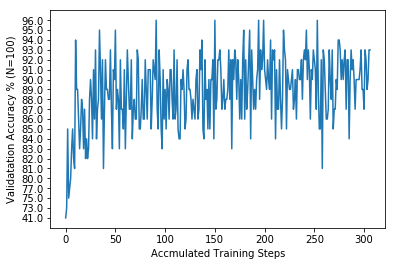

In [12]:
import sys
import re
import matplotlib.pyplot as plt

trainAccuracy = []
crossEntropy = []
validationAccuracy = []
'''
INFO:tensorflow:2018-07-19 12:54:25.567241: Step 0: Train accuracy = 60.0%
INFO:tensorflow:2018-07-19 12:54:25.570262: Step 0: Cross entropy = 1.539507
INFO:tensorflow:2018-07-19 12:54:26.325964: Step 0: Validation accuracy = 41.0% (N=100)
'''


def main():
    with open("retrain.log", 'r') as logfile:
        for line in logfile:
            if ("Train accuracy" in line):
                line=line[69:]
                line.rstrip("%\n")
                line = re.sub(r"[\n\t\s%=]*","",line)
                trainAccuracy.append(line)
            if ("Cross entropy" in line):
                line=line[68:]
                line = re.sub(r"[\n\t\s%=]*","",line)
                crossEntropy.append(line)
            if("Validation accuracy" in line):
                line=line[74:]
                line = re.sub(r"[\n\t\s%=]*","",line)
                line=line[:-6]
                validationAccuracy.append(line)

    #plt.plot(trainAccuracy)
    plt.plot(validationAccuracy)
    plt.ylabel("Validatation Accuracy % (N=100)")
    plt.xlabel("Accmulated Training Steps")
    plt.show()
 
if __name__== "__main__":
  main()

